In [2]:
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, sosfiltfilt, welch, periodogram
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.widgets import Slider
from matplotlib.colors import TwoSlopeNorm
from scipy.interpolate import PchipInterpolator
import h5py
import cv2
import pandas as pd
from ipywidgets import HBox, VBox, IntSlider, Dropdown, Play, jslink, HTML
from IPython.display import display, clear_output
import os, time, re
import matplotlib.animation as animation
import imageio_ffmpeg
import cv2
from skimage.draw import polygon2mask
from skimage.measure import find_contours
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle
from scipy import interpolate

%config InlineBackend.close_figures = False

In [3]:
def analytic_signal_fft_nd(x, axis=-1):
    """
    FFT-based Hilbert transform to get analytic signal along a given axis.
    Works for real x with arbitrary extra dims.
    Returns complex analytic signal with same shape.
    """
    x = np.asarray(x)
    n = x.shape[axis]
    X = np.fft.fft(x, n=n, axis=axis)
    h = np.zeros(n, dtype=float)
    if n % 2 == 0:
        h[0] = 1.0
        h[n//2] = 1.0
        h[1:n//2] = 2.0
    else:
        h[0] = 1.0
        h[1:(n+1)//2] = 2.0
    # reshape h to broadcast along 'axis'
    shape = [1]*x.ndim
    shape[axis] = n
    H = h.reshape(shape)
    Z = np.fft.ifft(X * H, axis=axis)
    return Z

def gaussian_filter_nan(a, sigma, truncate=3.0, mode='reflect'):
    """
    NaN-aware Gaussian that (i) renormalizes by valid support and
    (ii) guarantees the output is NaN exactly where input is NaN.
    Works for (ny,nx) or (ny,nx,nt); use sigma like (sx,sy,0.0) for movies.
    """
    orig_valid = np.isfinite(a)
    a_filled   = np.where(orig_valid, a, 0.0).astype(float)

    # Constant padding avoids reflecting values across the mask boundary
    w = gaussian_filter(orig_valid.astype(float), sigma=sigma,
                        truncate=truncate, mode='constant', cval=0.0)
    b = gaussian_filter(a_filled, sigma=sigma,
                        truncate=truncate, mode='constant', cval=0.0)

    out = b / (w + 1e-12)
    # (i) keep NaNs where there was no valid support at all
    out[w < 1e-12] = np.nan
    # (ii) clamp to original mask: never “create” new pixels
    out[~orig_valid] = np.nan
    return out

def compute_phase_gradient(
    movie, Fs,
    sigma_px=1.0, truncate=3.0, mode='reflect',
    dx=1.0, dy=1.0
):
    """
    End-to-end analysis with the SAME methods as your current function:
      - Optional temporal bandpass (Butterworth, sosfiltfilt)
      - Analytic signal via analytic_signal_fft_nd
      - Amplitude & wrapped phase
      - Wrap-safe smoothing by normalizing to unit-magnitude complex, then Gaussian
      - Phase gradient via complex-product forward differences, sign-flipped (g = -∇φ)
      - Gradient magnitude

    Parameters
    ----------
    movie : (ny, nx, nt) real array
    Fs    : sampling rate (Hz)
    lo, hi, order : temporal bandpass parameters
    sigma_px, truncate, mode : spatial Gaussian params for complex smoothing
    dx, dy : pixel size (x,y)
    amp_mask : bool, apply your mask_low_amp() to z and amp
    bandpass : bool, apply bandpass before analytic signal
    identify_source : bool, compute argmax of divergence per frame for convenience
    gp : bool, whether to compute generalized phase

    Returns
    -------
    results : dict with keys:
        't', 'movie_bp', 'z', 'amp', 'phi', 'z_s',
        'gx', 'gy', 'grad_mag', 'div', 'curl', 'source'
    """
    nt, nx, ny = movie.shape
    t = np.arange(nt) / Fs

    # ---- 2) Analytic signal, amplitude, phase (unchanged) ----
    z = analytic_signal_fft_nd(movie, axis=0)
    amp = np.abs(z)

    # ---- Optional low-amp mask (unchanged) ----
    phi = np.angle(z)

    # ---- 3) Normalize amplitude ----
    eps = 1e-12
    
    # ---- Safe unit complex field: z_unit = z / amp ----
    # valid where both z and amp are finite and amp > eps
    valid = np.isfinite(z) & np.isfinite(amp) & (amp > eps)

    z_s = np.full_like(z, np.nan, dtype=np.complex128)     # preserves mask
    np.divide(z, amp, out=z_s, where=valid)             # no divide at invalids

    # ---- 4) Phase gradient via complex-product forward diffs (unchanged) ----
    # gx ~ angle( z(x+1,y) * conj(z(x,y)) ) / dx ; same for gy, then sign flip for g = -∇φ
    z_xp1 = np.roll(z_s, -1, axis=2)
    dphi_x = np.angle(z_xp1 * np.conj(z_s))
    gx = dphi_x / dx
    gx[:, :, -1] = np.nan  # invalidate forward edge

    z_yp1 = np.roll(z_s, -1, axis=1)
    dphi_y = np.angle(z_yp1 * np.conj(z_s))
    gy = dphi_y / dy
    gy[:, -1, :] = np.nan  # invalidate forward edge

    # Convention match: g = -∇φ
    gx, gy = -gx, -gy
    grad_mag = np.sqrt(gx**2 + gy**2)

    # take unit vectors of gradient
    eps = 1e-12
    gx = gx / (grad_mag + eps)
    gy = gy / (grad_mag + eps)
    
    # ---- Smooth the unit vector field ----
    sigma_px = 3
    u = gx + 1j * gy
    ur = gaussian_filter_nan(np.real(u), sigma=(sigma_px, sigma_px, 0.0), truncate=truncate)
    ui = gaussian_filter_nan(np.imag(u), sigma=(sigma_px, sigma_px, 0.0), truncate=truncate)
    u_s = ur + 1j*ui

    # ---- Safe renormalization: u_hat = u_s / |u_s| ----
    mag    = np.abs(u_s)
    validU = np.isfinite(u_s) & np.isfinite(mag) & (mag > eps)

    u_hat = np.full_like(u_s, np.nan, dtype=np.complex128)
    np.divide(u_s, mag, out=u_hat, where=validU)

    gx, gy = np.real(u_hat), np.imag(u_hat)

    return gx, gy

def mean_phase_gradient(
    gx, gy, clip, fps, 
    t_start_s, t_end_s, 
    x_range=(90,110), y_range=(150,170),
    weight=True,
    plot=False
    ):
    """
    Time/space average of phase-gradient unit vectors in a rectangular ROI,
    for data shaped (t, y, x). Optionally plots a gx frame with ROI overlay.

    Parameters
    ----------
    gx, gy : arrays shaped (t, y, x)
        Unit-vector components of the phase gradient.
    clip : array shaped (t, y, x)
        ΔF/F movie clip
    fps : float
        Frames per second for time indexing.
    t_start_s, t_end_s : float
        Time window in seconds (half-open [start, end)).
    x_range, y_range : tuple[int, int]
        Inclusive pixel index ranges for the ROI.
    weights : None or array shaped (t, y, x)
        Optional weights (e.g. amplitude) for averaging.
    plot : bool
        If True, show a gx frame with the ROI rectangle.

    Returns
    -------
    "theta_deg": angle (degrees),
    "R": mean resultant length (0–1)
    """
    # --- indices ---
    t0 = int(np.floor(t_start_s * fps))
    t1 = int(np.ceil(t_end_s * fps))
    t0 = max(0, min(t0, gx.shape[0]))
    t1 = max(0, min(t1, gx.shape[0]))

    y0, y1_inc = y_range
    x0, x1_inc = x_range
    ys = slice(y0, y1_inc + 1)
    xs = slice(x0, x1_inc + 1)

    gx_roi = gx[t0:t1, ys, xs]
    gy_roi = gy[t0:t1, ys, xs]
    valid = np.isfinite(gx_roi) & np.isfinite(gy_roi)

    if weight:
        weights = np.abs(clip)
        w = weights[t0:t1, ys, xs].astype(float)
        w[~valid | ~np.isfinite(w)] = 0.0
    else:
        w = np.ones_like(gx_roi)

    wx = w * gx_roi
    wy = w * gy_roi
    denom = np.sum(w)

    mx = np.sum(wx) / denom
    my = np.sum(wy) / denom
    R = np.hypot(mx, my)
    theta = np.arctan2(my, mx)
    theta_deg = np.degrees(theta)

    # --- optional plot ---
    if plot:
        
        fdisp = (t0 + t1) // 2  # middle frame
        clip_frame = clip[fdisp]

        fig, ax = plt.subplots(figsize=(5.2, 4.6), constrained_layout=True)
        im = ax.imshow(clip_frame, origin='upper', vmin=-0.04, vmax=0.04, cmap='seismic')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='ΔF/F')

        # Draw ROI rectangle
        rect = Rectangle((x0, y0), x1_inc - x0 + 1, y1_inc - y0 + 1,
                         fill=False, color='black', lw=1.5)
        ax.add_patch(rect)

        # Draw mean direction arrow
        cx = (x0 + x1_inc) / 2
        cy = (y0 + y1_inc) / 2
        scale = max(x1_inc - x0, y1_inc - y0) * 0.6
        ax.arrow(cx, cy, mx * scale, my * scale,
                    width=0.5, head_width=3, color='black',
                    length_includes_head=True)

        ax.set_title(f"Mean Phase Gradient Direction for {t_start_s}-{t_end_s} s\n Vector Coherence = {R:.2f}")
        ax.set_xlabel("x index")
        ax.set_ylabel("y index") 

    return float(theta_deg), float(R)

In [4]:
def load_movie(mouse, date, file):
    if mouse=='cfm001mjr' or mouse=='cfm002mjr':
        path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised_2.h5'
    else:
        path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised.h5'

    with h5py.File(path, 'r') as mov_file:
        specs = mov_file["specs"]
        fps = specs['fps'][()].squeeze()
        raw_mask = specs["extra_specs"]["mask"][()].squeeze()
        binning = specs["binning"][()].squeeze()

        movie = mov_file['mov']
        
    return movie, fps, raw_mask, binning

def mask_movie(movie, raw_mask, binning, flip=False):
    mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning,
                      interpolation=cv2.INTER_LINEAR)
    movie_size = movie.shape[1:3]
    mask = mask[:movie_size[0], :movie_size[1]].astype(bool)
    if flip:
        mask = np.flipud(mask)
    
    # Broadcast mask to movie shape
    mask = mask[None, :, :]  # if movie is (t, y, x)
    
    out = movie.astype(float).copy()
    out[:, ~mask[0]] = np.nan
    return out

def find_trials(df, **filters):
    """
    Finds trials from df that match the specified properties.

    Args:
    - df (pd.DataFrame): DataFrame containing trial information.
    - filters (dict): Key-value pairs of column names and values to filter by.
      - Supported keys include 'Date', 'Recording', 'PerceptualCat', 'Rewarded', etc.
      - If a parameter is not specified, it is ignored in filtering.

    Returns:
    - pd.DataFrame: Filtered dataframe containing trials that meet the specified criteria
        - Includes columns: ['AnimalCode', 'TrialID', 'Date', 'BFMTime', 'Duration', 'File', 'ValidTrial?']
    """

    # Start with full DataFrame and filter only valid trials
    filtered_df = df.copy()
    filtered_df = filtered_df[filtered_df['ValidTrial?'] == True] 

    # Apply dynamic filtering based on provided arguments
    for key, value in filters.items():
        if key in df.columns and value is not None:
            if isinstance(value, list):  # Check if the filter is a list
                filtered_df = filtered_df[filtered_df[key].isin(value)]
            else:
                filtered_df = filtered_df[filtered_df[key] == value]

    return filtered_df[["AnimalCode", "TrialID", "Date", "BFMTime", "Duration", "File", 'ValidTrial?']]

def extract_trials(mouse, spontaneous=False, bandpass=False, **filters):
    trial_info_path = f"C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/trial_info/TrialInfo_{mouse}.csv"
    df_all = pd.read_csv(trial_info_path)
    df = find_trials(df_all, **filters)
    unique_recordings = df[['AnimalCode', 'File', 'Date']].drop_duplicates() # Identify unique recordings
    print(f"Found {len(df)} trials.")
    if len(df) == 0:
        return 0, 0, 0, 0

    trials = {}
    durations = {}
    gradients = {}

    # Load and process movies for each unique recording
    for _, row in unique_recordings.iterrows():
        mouse = row['AnimalCode']
        date = row['Date']
        file = row['File']

        if mouse=='cfm001mjr' or mouse=='cfm002mjr':
            path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised_2.h5'
        else:
            path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised.h5'

        with h5py.File(path, 'r') as mov_file:
            specs = mov_file["specs"]
            fps = specs['fps'][()].squeeze()
            raw_mask = specs["extra_specs"]["mask"][()].squeeze()
            binning = specs["binning"][()].squeeze()
            raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()].squeeze()
            spaceorigin = specs["spaceorigin"][()].squeeze()

            movie = mov_file['mov']

            # Extract trials for this movie
            df_trials = df[(df['AnimalCode'] == mouse) & (df['Date'] == date) & (df['File'] == file)]

            for _, trial in df_trials.iterrows():
                bfm_time = trial['BFMTime']  # Trial start time in BFM coordinates
                trial_id = trial['TrialID'][7:]
                durations[trial_id] = trial['Duration']

                try:
                        # Compute frame range for this trial
                    if spontaneous:
                        start_frame = int((bfm_time + 2) * fps)
                        end_frame = int((bfm_time + 4) * fps)                        
                    else:
                        start_frame = int((bfm_time - 1) * fps)
                        end_frame = int((bfm_time + 1) * fps)

                    # Extract trial snippet
                    trial_clip = movie[start_frame:end_frame]

                    flip = False
                    if mouse == 'cfm001mjr' or mouse == 'cfm002mjr' or mouse == 'cmm002mjr' or mouse == 'cmm003mjr' or mouse == 'rfm002mjr':
                        flip = True
                    trial_clip = mask_movie(trial_clip, raw_mask, binning, flip=flip)
                    if mouse == 'cfm003mjr' or mouse == 'cfm004mjr' or mouse == 'cmm001mjr':
                        trial_clip = np.flip(trial_clip, axis=1)

                    gx, gy = compute_phase_gradient(trial_clip, fps)
                    
                    trials[trial_id] = trial_clip
                    gradients[trial_id] = (gx, gy)
                except Exception as e:
                    print(e)

    return trials, fps, durations, gradients

Found 9 trials.


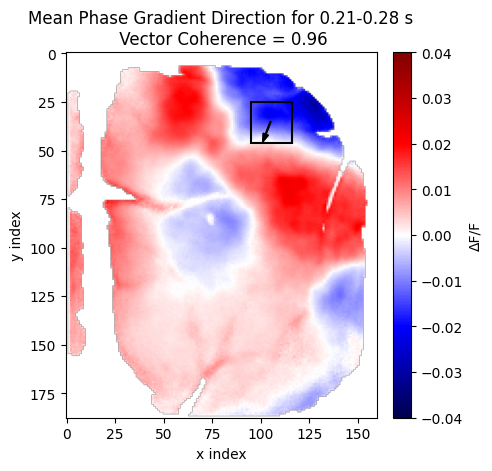

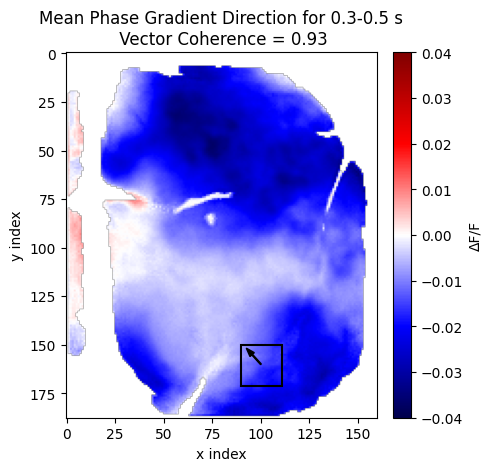

In [ ]:
mouse = "cfm002mjr"
date = 240517
rec = 'meas01' 

trials, fps, durations, gradients = extract_trials(mouse, spontaneous=False, Date=date, File=rec, TrialType=['HC Hit (3)', 'MC Hit (2)'])

clip = trials['cfm002mjr/20240517/meas01/trial006']
gx, gy = gradients['cfm002mjr/20240517/meas01/trial006']

theta, R = mean_phase_gradient(
            gx, gy, clip, fps,
            t_start_s=0.21, t_end_s=0.28,
            x_range=(95,115), y_range=(25,45),
            plot=True, weight=True
             )

theta, R = mean_phase_gradient(
            gx, gy, clip, fps,
            t_start_s=0.30, t_end_s=0.50,
            plot=True, weight=True
            )

In [5]:
def collect_angles_by_stage(
    trials, gradients, fps,
    x_range=(95,115), y_range=(25,45),
    weight=True, plot=False,
    coherence_min=None,
    bin_width_s=0.25,
    stage_windows=None,
    spontaneous=False,
):
    """
    Collapse many trials into stage-wise angle/weight lists in one pass.

    Parameters
    ----------
    trials : dict[str, np.ndarray]
        trial_id -> clip (t, y, x), ~2 s long.
    gradients : dict[str, tuple[np.ndarray, np.ndarray]]
        trial_id -> (gx, gy), each (t, y, x), same t as clip.
    fps : float
        Frames per second for time indexing.
    x_range, y_range : (int, int)
        Inclusive ROI pixel ranges.
    weight : bool
        If True, mean uses |ΔF/F| as weights (as in mean_phase_gradient).
    plot : bool
        If True, passes plot=True into mean_phase_gradient (many figures).
    coherence_min : float or None
        If set, discard bins with R < coherence_min.
    bin_width_s : float
        Duration of each temporal bin (default 0.25 s).
    stage_windows : dict[str, tuple[float, float]] or None
        If None, uses:
            {"pre": (0.00, 1.00), "stim": (1.00, 1.50), "post": (1.50, 2.00)}
    spontaneous : bool
        If True, do not split into pre/stim/post; instead bin the
    full clip for each trial and store under the single key 'spont'.

    Returns
    -------
    data : dict[str, dict[str, list[float]]]
        {
          "pre" : {"theta_deg": [...], "R": [...]},
          "stim": {"theta_deg": [...], "R": [...]},
          "post": {"theta_deg": [...], "R": [...]},
        }
        OR {"spont": {"theta_deg": [...], "R": [...]}}
        Aggregated across all trials and bins.

    """
    if spontaneous:
        # Single bucket for spontaneous segments
        out = {"spont": {"theta_deg": [], "R": []}}
        trial_ids = sorted(set(trials) & set(gradients))

        for tid in trial_ids:
            clip = trials[tid]
            gx, gy = gradients[tid]
            clip_len = clip.shape[0] / fps

            # half-open bins [t0, t1) across full clip
            starts = np.arange(0.0, clip_len, bin_width_s)
            ends = np.minimum(starts + bin_width_s, clip_len)

            for t0, t1 in zip(starts.tolist(), ends.tolist()):
                theta_deg, R = mean_phase_gradient(
                    gx, gy, clip, fps,
                    t_start_s=t0, t_end_s=t1,
                    x_range=x_range, y_range=y_range,
                    weight=weight, plot=plot
                )
                if (coherence_min is not None) and (R < coherence_min):
                    continue
                out["spont"]["theta_deg"].append(float(theta_deg))
                out["spont"]["R"].append(float(R))

        return out

    # --- original staged behavior unchanged below ---
    if stage_windows is None:
        stage_windows = {"pre": (0.00, 1.00), "stim": (1.00, 1.50), "post": (1.50, 2.00)}

    out = {k: {"theta_deg": [], "R": []} for k in ("pre", "stim", "post")}
    trial_ids = sorted(set(trials) & set(gradients))

    stage_bins = {}
    for stage, (a, b) in stage_windows.items():
        starts = np.arange(a, b, bin_width_s)
        ends = np.minimum(starts + bin_width_s, b)
        stage_bins[stage] = list(zip(starts.tolist(), ends.tolist()))

    for tid in trial_ids:
        clip = trials[tid]
        gx, gy = gradients[tid]

        for stage, bins in stage_bins.items():
            for t0, t1 in bins:
                theta_deg, R = mean_phase_gradient(
                    gx, gy, clip, fps,
                    t_start_s=t0, t_end_s=t1,
                    x_range=x_range, y_range=y_range,
                    weight=weight, plot=plot
                )
                if (coherence_min is not None) and (R < coherence_min):
                    continue
                out[stage]["theta_deg"].append(float(theta_deg))
                out[stage]["R"].append(float(R))

    return out

def plot_phase_rose(stage_data, title="ROI-Averaged Phase Gradient Directions", spontaneous=False):
    """
    Make a clean, R-weighted polar (rose) histogram of mean phase directions.

    When spontaneous=True, expect a single key 'spont' in stage_data and plot it
    as one group. Otherwise, plot the usual 'pre', 'stim', 'post' groups.
    """

    # --- fixed settings (kept simple) ---
    bins = 24
    alpha = 0.6
    figsize = (6, 6)
    colors = {"pre": "cornflowerblue", "stim": "coral", "post": "lightgreen", "spont": "mediumpurple"}

    def _wrap0_360(deg_array):
        a = np.asarray(deg_array, dtype=float) % 360.0
        a[a < 0] += 360.0
        return a

    # choose which groups to plot
    groups = ("spont",) if spontaneous else ("pre", "stim", "post")

    # --- build per-group angle arrays (radians) and R weights ---
    stage_angles = {}
    stage_weights = {}
    for stage in groups:
        d = stage_data.get(stage, {"theta_deg": [], "R": []})
        if len(d["theta_deg"]) == 0:
            stage_angles[stage] = np.array([])
            stage_weights[stage] = np.array([])
            continue
        th_rad = np.deg2rad(_wrap0_360(d["theta_deg"]))
        R = np.asarray(d["R"], dtype=float)
        stage_angles[stage]  = th_rad
        stage_weights[stage] = R  # linear R weighting

    # --- per-stage equalization (no-op if a single group) ---
    nonempty = [s for s in groups if stage_angles[s].size > 0]
    if nonempty:
        target = 1.0 / len(nonempty)
        for s in nonempty:
            w = stage_weights[s]
            ssum = w.sum()
            stage_weights[s] = (w / ssum) * target if ssum > 0 else np.full_like(w, target / max(1, w.size))

    # --- plotting ---
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="polar")

    bin_edges = np.linspace(0.0, 2*np.pi, bins + 1)
    widths = np.diff(bin_edges)
    centers = bin_edges[:-1] + widths / 2

    for stage in groups:
        ang = stage_angles[stage]
        if ang.size == 0:
            continue
        w = stage_weights[stage]
        counts, _ = np.histogram(ang, bins=bin_edges, weights=w)
        ax.bar(centers, counts, width=widths, align="center",
               alpha=alpha, color=colors[stage], 
               edgecolor="dimgrey", linewidth=0.5,
               label=f"{stage} (n={ang.size})")

    ax.set_theta_zero_location('E')   # 0° at right
    ax.set_theta_direction(-1)        # clockwise
    ax.set_title(title)
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.10), frameon=False)
    ax.set_yticklabels([])            # hide radial numbers
    ax.set_yticks([])

    return fig, ax

def R_histogram(stage_data, title="Vector Coherence (R) Distribution", spontaneous=False):
    """
    Plot the distribution of vector coherence R as a standard histogram.

    Parameters
    ----------
    stage_data : dict
        Output of collect_angles_by_stage(...):
        {
          "pre":  {"theta_deg":[...], "R":[...]},
          "stim": {"theta_deg":[...], "R":[...]},
          "post": {"theta_deg":[...], "R":[...]},
          # or, if spontaneous=True:
          "spont":{"theta_deg":[...], "R":[...]}
        }
    title : str
        Figure title.
    spontaneous : bool
        If True, expect a single 'spont' key and plot it as one group.
        If False, plot the usual 'pre', 'stim', 'post' groups.

    Behavior (kept simple and opinionated)
    --------------------------------------
    • Fixed bins over R ∈ [0, 1] (20 bins)
    • Per-group density normalization (area under each group’s histogram = 1)
      so shapes are comparable even with different sample counts
    • Same colors and labels as the rose plot
    • Thin black edge on bars for clarity
    """

    # Fixed styling and binning
    bins = np.linspace(0.0, 1.0, 21)     # 20 bins over [0,1]
    alpha = 0.6
    figsize = (6, 4.0)
    colors = {"pre": "cornflowerblue", "stim": "coral", "post": "lightgreen", "spont": "mediumpurple"}

    groups = ("spont",) if spontaneous else ("pre", "stim", "post")

    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

    # Plot each group as a density histogram
    for stage in groups:
        d = stage_data.get(stage, {"theta_deg": [], "R": []})
        R = np.asarray(d.get("R", []), dtype=float)
        if R.size == 0:
            continue

        ax.hist(
            R, bins=bins, density=True,
            alpha=alpha, color=colors[stage],
            edgecolor="black", linewidth=0.5,
            label=f"{stage} (n={R.size})",
            histtype="bar"  # filled bars with outline
        )

    # Axes cosmetics for cross-figure comparability
    ax.set_xlim(0.0, 1.0)
    ax.set_xlabel("Vector coherence R")
    ax.set_ylabel("Probability density")
    ax.set_title(title)
    ax.legend(frameon=False)
    ax.grid(True, axis="y", linestyle=":", linewidth=0.8, alpha=0.7)

    return fig, ax

In [6]:
def analyze_psd_by_stage(
    trial_clips, fps,
    spontaneous=False,
    stage_windows=None,
    x_range=(95,115), y_range=(25,45),
    plot=False, title=None
):
    """
    Compute mean PSDs (1–20 Hz) for short movie clips, aggregated by stage (or 'spont'),
    after cropping to a rectangular ROI.
    """
    if not spontaneous and stage_windows is None:
        stage_windows = {"pre": (0.00, 1.00), "stim": (1.00, 1.50), "post": (1.50, 2.00)}

    stages = ["spont"] if spontaneous else list(stage_windows.keys())
    data = {k: {"freq": [], "mean_psd": [], "dom_freq": []} for k in stages}

    # --- helper functions ---
    def _crop(movie, xr, yr):
        """Crop (t, y, x) movie to ROI defined by [xr[0]:xr[1]) and [yr[0]:yr[1])."""
        t, H, W = movie.shape
        x0, x1 = int(xr[0]), int(xr[1])
        y0, y1 = int(yr[0]), int(yr[1])
        x0 = max(0, min(x0, W)); x1 = max(0, min(x1, W))
        y0 = max(0, min(y0, H)); y1 = max(0, min(y1, H))
        if (x1 - x0) < 1 or (y1 - y0) < 1:
            return None
        return movie[:, y0:y1, x0:x1]

    def _slice_clip(movie, start_s, end_s, fs):
        n = movie.shape[0]
        t0 = max(0, min(int(np.floor(start_s * fs)), n))
        t1 = max(0, min(int(np.floor(end_s * fs)), n))
        if t1 <= t0 or (t1 - t0) < 2:
            return None
        return movie[t0:t1]

    def _mean_psd_1to20Hz(movie):
        """Detrend each pixel, Hann periodogram on full segment, average pixels."""
        t, y, x = movie.shape
        X = movie.reshape(t, -1)
        valid = ~np.isnan(X).any(axis=0)
        if not np.any(valid):
            return None
        X = X[:, valid]
        freqs, Pxx = periodogram(
            X, fs=fps, window="hann", detrend="linear",
            scaling="density", axis=0, return_onesided=True
        )
        band =  (freqs <= 20.0)
        if not np.any(band):
            return None
        f = freqs[band]
        mpsd = np.mean(Pxx[band, :], axis=1)
        dom = float(f[np.argmax(mpsd)])
        return f, mpsd, dom

    # --- main loop ---
    for trial_id, clip in trial_clips.items():
        if clip is None or clip.ndim != 3 or clip.shape[0] < 2:
            continue
        cropped = _crop(clip, x_range, y_range)
        if cropped is None:
            continue

        if spontaneous:
            res = _mean_psd_1to20Hz(cropped)
            if res is None:
                continue
            f, mpsd, dom = res
            data["spont"]["freq"].append(f)
            data["spont"]["mean_psd"].append(mpsd)
            data["spont"]["dom_freq"].append(dom)
        else:
            for stage, (s0, s1) in stage_windows.items():
                sub = _slice_clip(cropped, s0, s1, fps)
                if sub is None:
                    continue
                res = _mean_psd_1to20Hz(sub)
                if res is None:
                    continue
                f, mpsd, dom = res
                data[stage]["freq"].append(f)
                data[stage]["mean_psd"].append(mpsd)
                data[stage]["dom_freq"].append(dom)

    # --- plotting ---
    if plot:
        title_map = {
            "spont": "Spontaneous (Inter-Trial Interval)",
            "pre": "Pre-Stimulus",
            "stim": "During Stimulus",
            "post": "Post-Stimulus"
        }

        if spontaneous:
            stages_to_plot = ["spont"]
            fig, ax = plt.subplots(figsize=(6, 4))
            axes = [ax]
        else:
            stages_to_plot = stages
            n = len(stages_to_plot)
            fig, axes = plt.subplots(1, n, figsize=(6*n, 4), sharey=False)  # independent y-axes
            if not isinstance(axes, (list, np.ndarray)):
                axes = [axes]

        for ax, st in zip(axes, stages_to_plot):
            Fs = data[st]["freq"]
            Ps = data[st]["mean_psd"]
            if len(Fs) == 0:
                ax.set_title(f"{title_map.get(st, st)} (no data)")
                continue

            ref_idx = np.argmax([f.size for f in Fs])
            f_ref = Fs[ref_idx]

            curves = []
            for f_i, p_i in zip(Fs, Ps):
                p_plot = np.interp(f_ref, f_i, p_i) if not np.allclose(f_i, f_ref) else p_i
                curves.append(p_plot)
                ax.plot(f_ref, p_plot, alpha=0.3, linewidth=0.8, c='dimgray')

            mean_curve = np.mean(np.vstack(curves), axis=0)
            ax.plot(f_ref, mean_curve, linewidth=2.0, label=f"{title_map.get(st, st)} mean", c='lightseagreen')

            #ax.set_xlim(1, 20)
            ax.set_xlabel("Frequency (Hz)")
            ax.set_ylabel("Power spectral density")
            ax.set_title(title_map.get(st, st))
            ax.grid(True, alpha=0.3)
            ax.legend()

        if title:
            fig.suptitle(title)
        fig.tight_layout()

        return fig, ax, data

    return data

In [10]:
def run_recording(mouse, date, rec=None, psd=True):
    if rec:
        print(f'Running Recording {mouse}/{date}/{rec}')
    else:
        print(f'Running Recording {mouse}/{date}')

    trial_types = [['HC Hit (3)', 'MC Hit (2)'], ['HC No Report (9)', 'MC No Report (8)', 'LC No Report (7)'], ['MC Miss (5)', 'Incorrect Reject (6)']]
    titles = ['High and Medium Contrast Hit Trials', 'No Report Trials (Mouse in Attrition)', 'High and Medium Contrast Miss Trials']

    regions = {'SSC' : [(95,115), (25,45)], 'V1': [(90,110), (150,170)]}

    for i, trial_type in enumerate(trial_types):
        try:
            trials, fps, durations, gradients = extract_trials(mouse, spontaneous=False, Date=date, File=None, TrialType=trial_type)

            for key in regions:

                x_range, y_range = regions[key][0], regions[key][1]

                results = collect_angles_by_stage(
                    trials, gradients, fps,
                    x_range=x_range, y_range=y_range)

                # Polar rose plot
                fig, ax = plot_phase_rose(results, title=f"{key}: {titles[i]}")

                display(fig)
                plt.close(fig)

                if psd:
                    fig, ax, psd_results = analyze_psd_by_stage(trials, fps, x_range=x_range, y_range=y_range, plot=True, title=f"{key}: {titles[i]}")

                    display(fig)
                    plt.close(fig)
        
        except:
            print(f'Failed {trial_type}')

## cfm002mjr/240517/meas01

Running Recording cfm002mjr/240517/None
Found 22 trials.


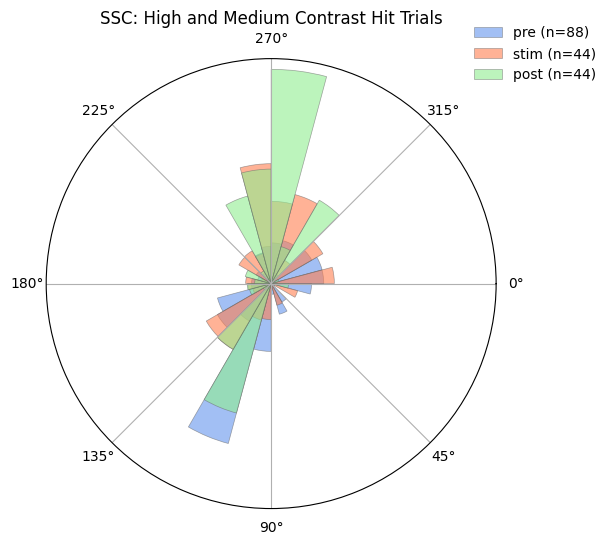

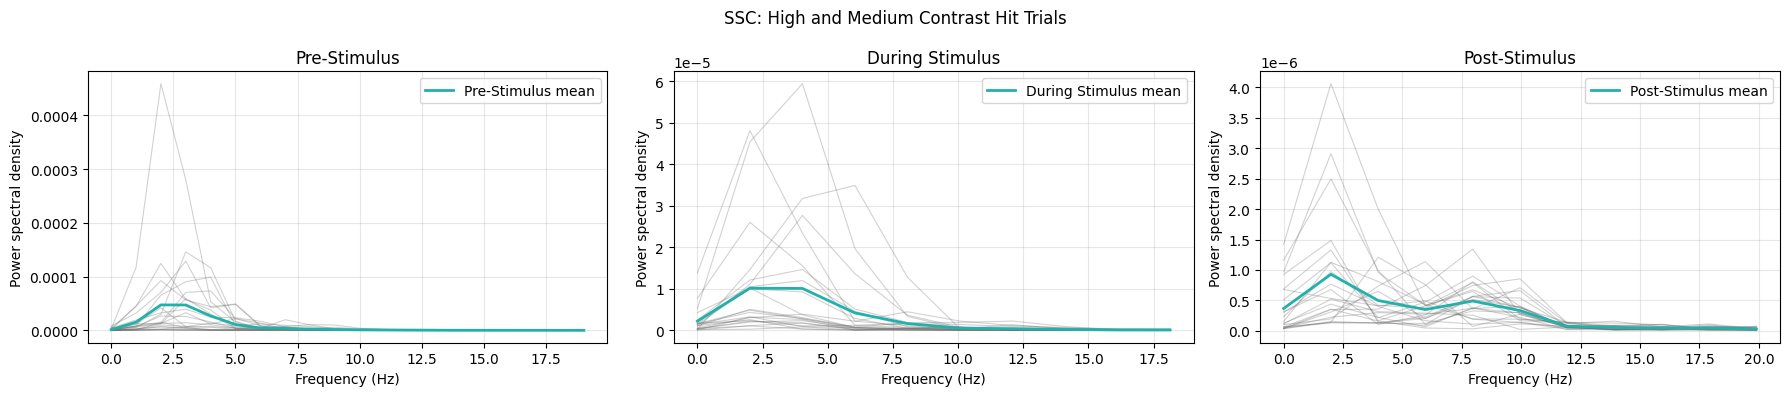

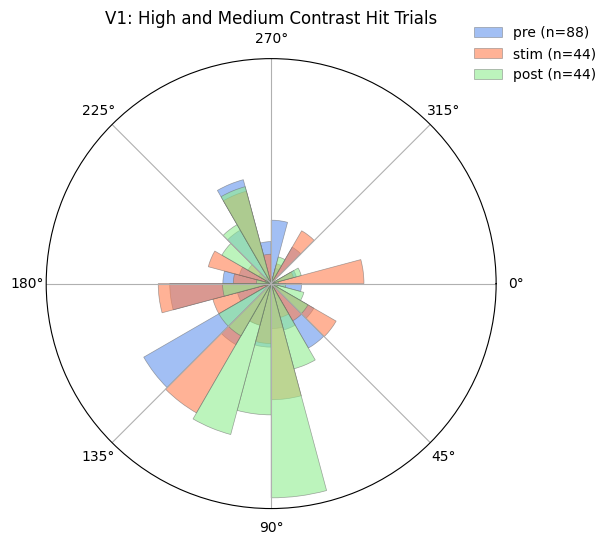

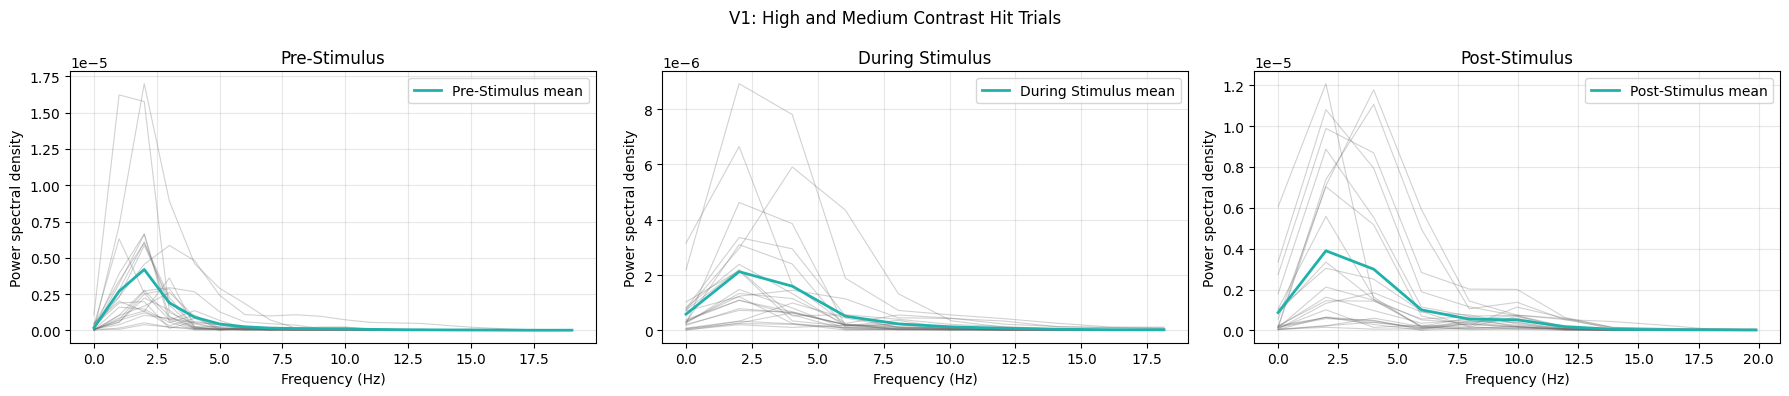

Found 150 trials.


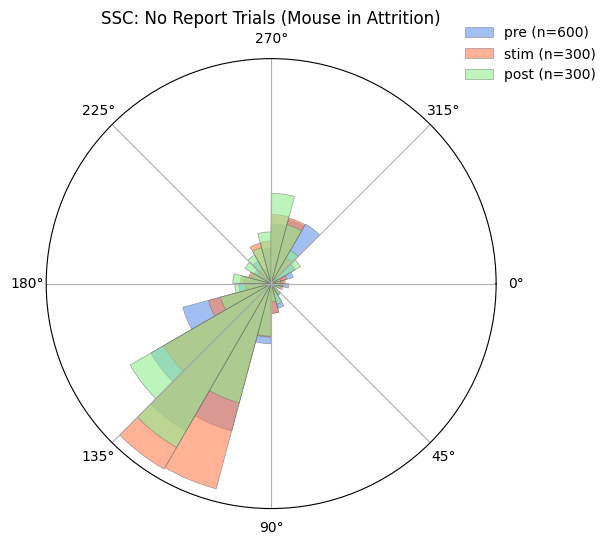

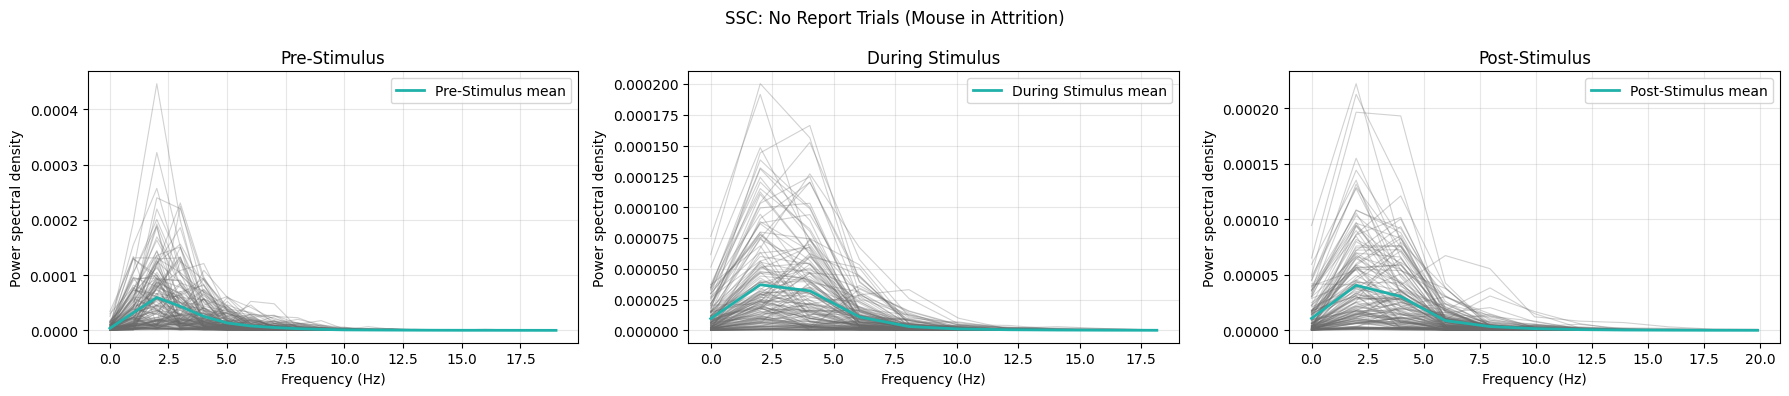

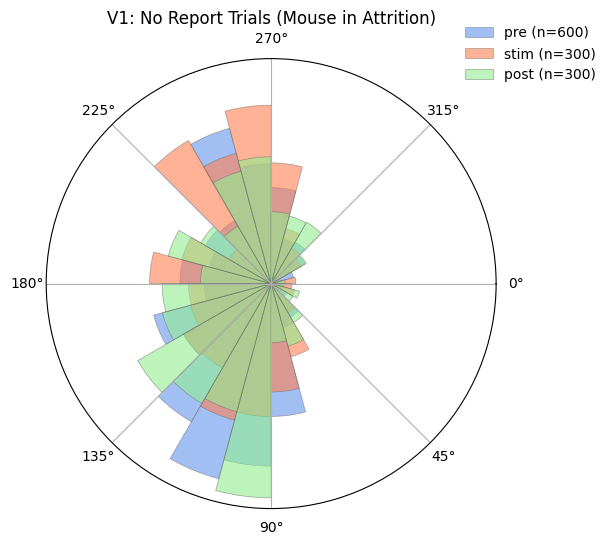

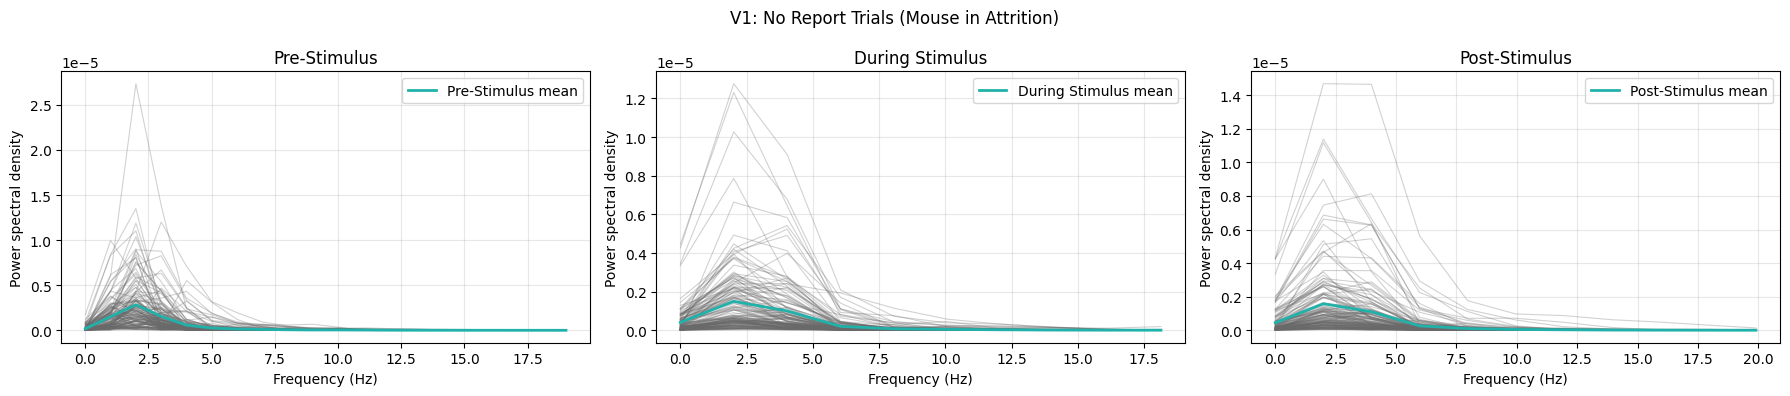

Found 40 trials.


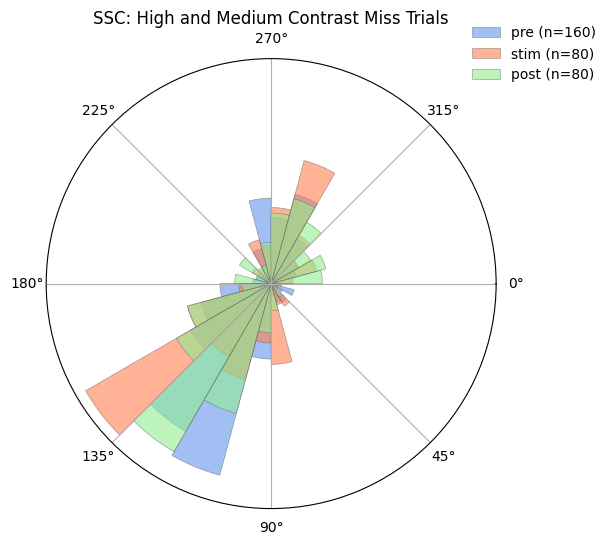

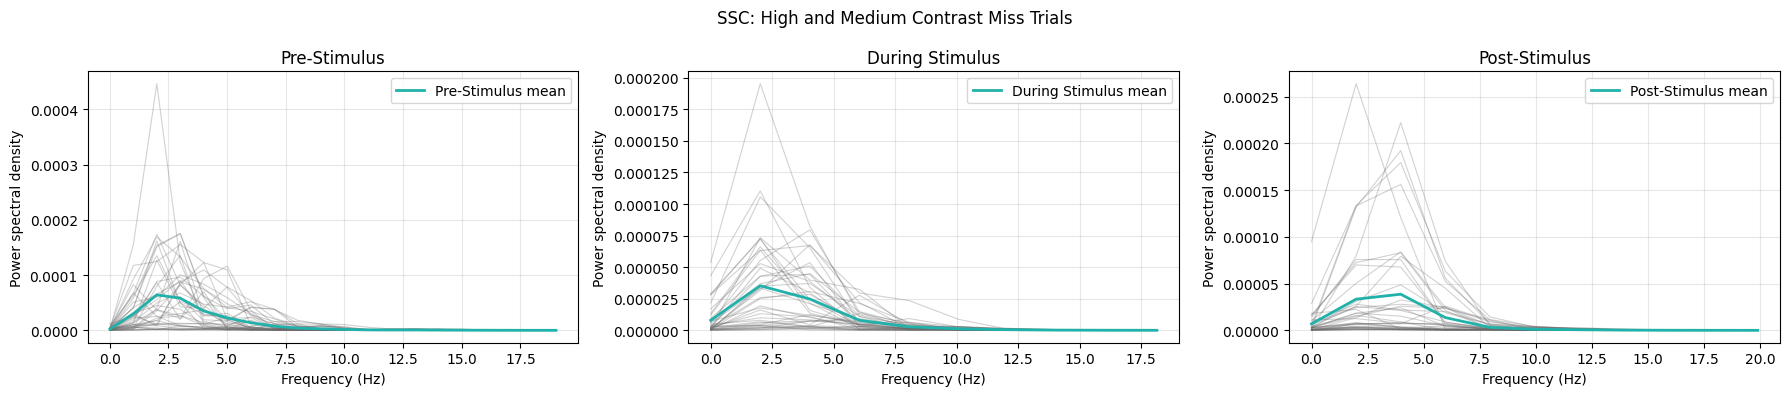

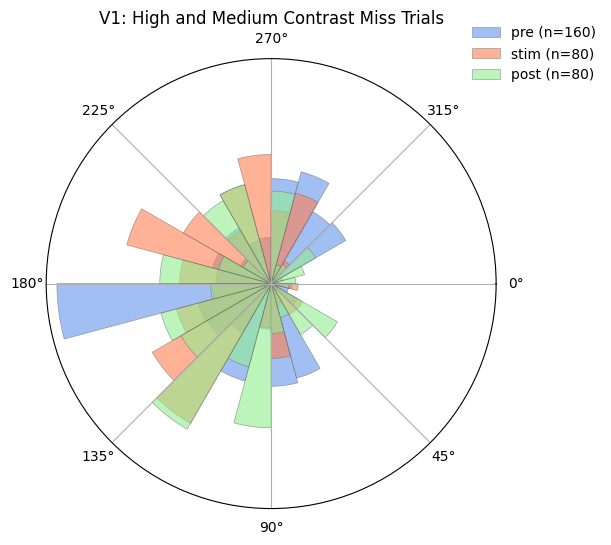

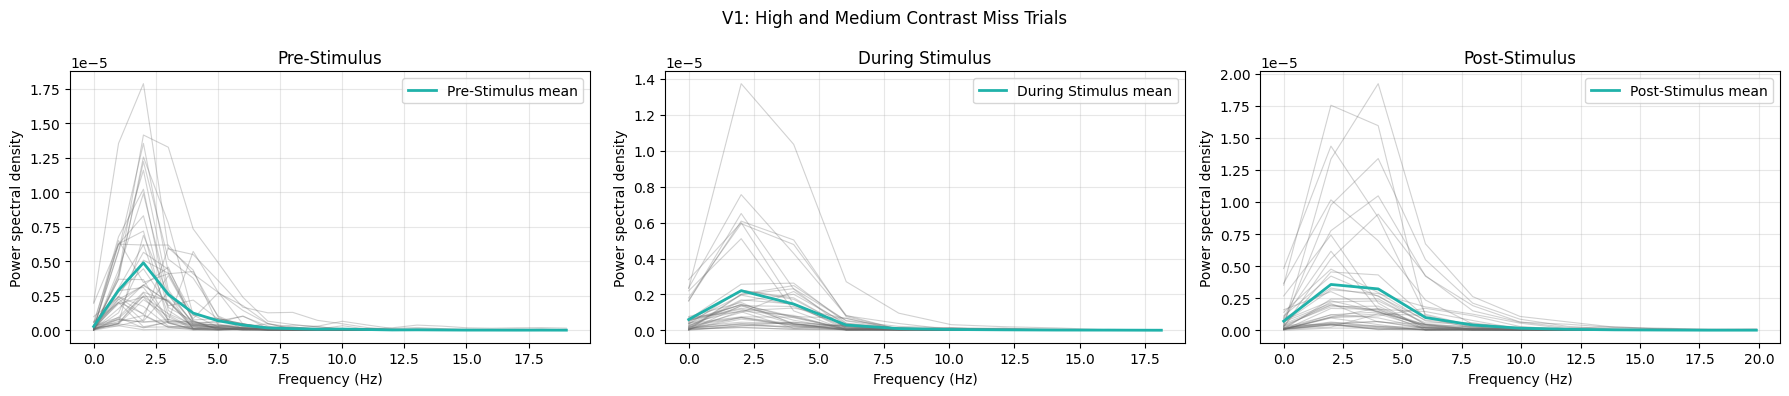

In [9]:
mouse = "cfm002mjr"
date = 240517

run_recording(mouse, date, rec=None, psd=True)

Running Recording cfm002mjr/240517/meas01
Found 9 trials.


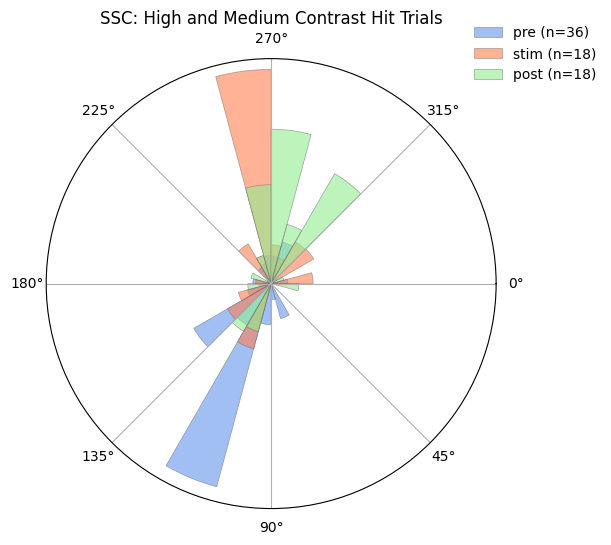

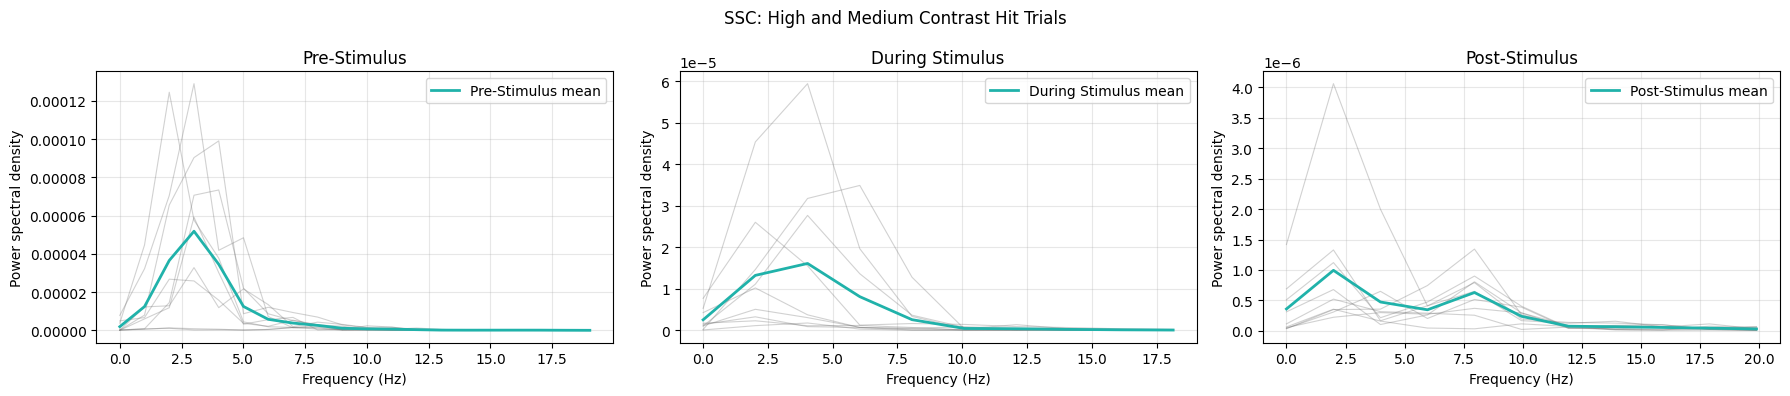

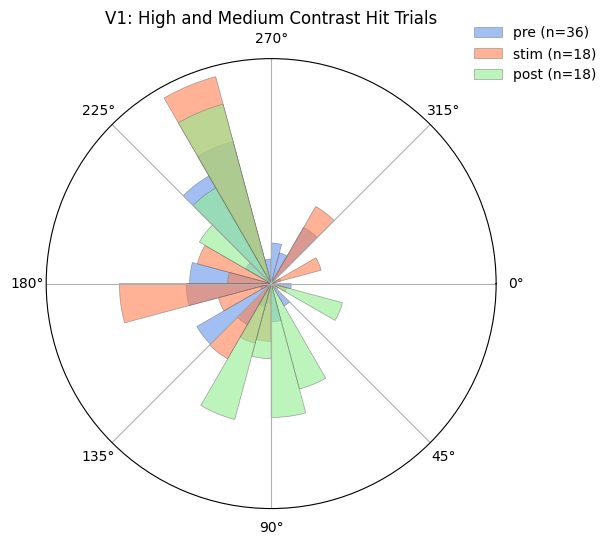

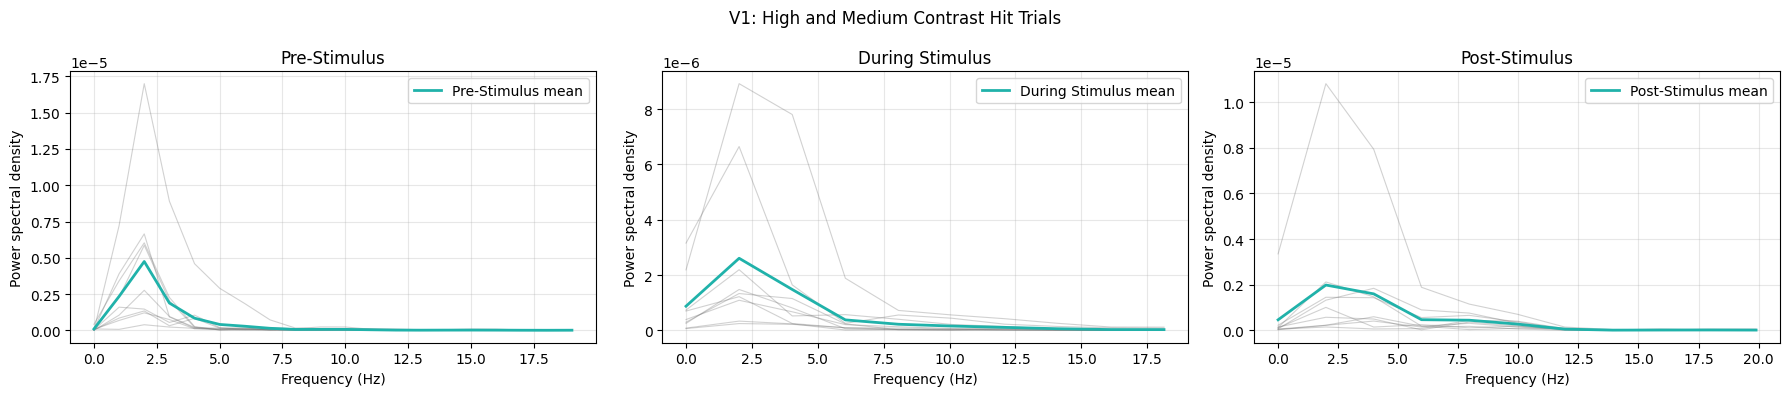

Found 70 trials.


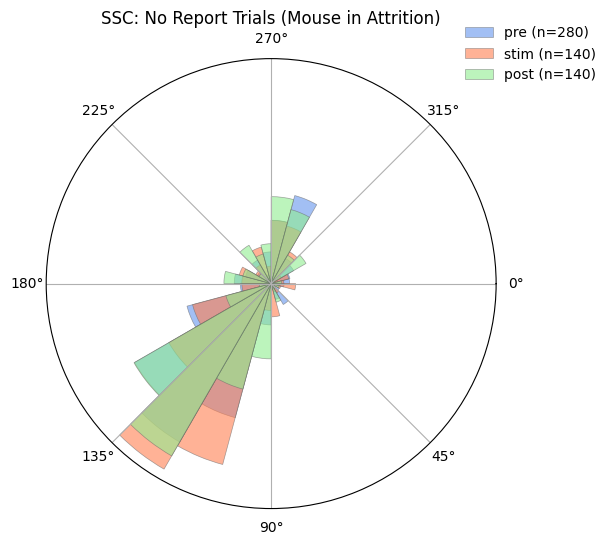

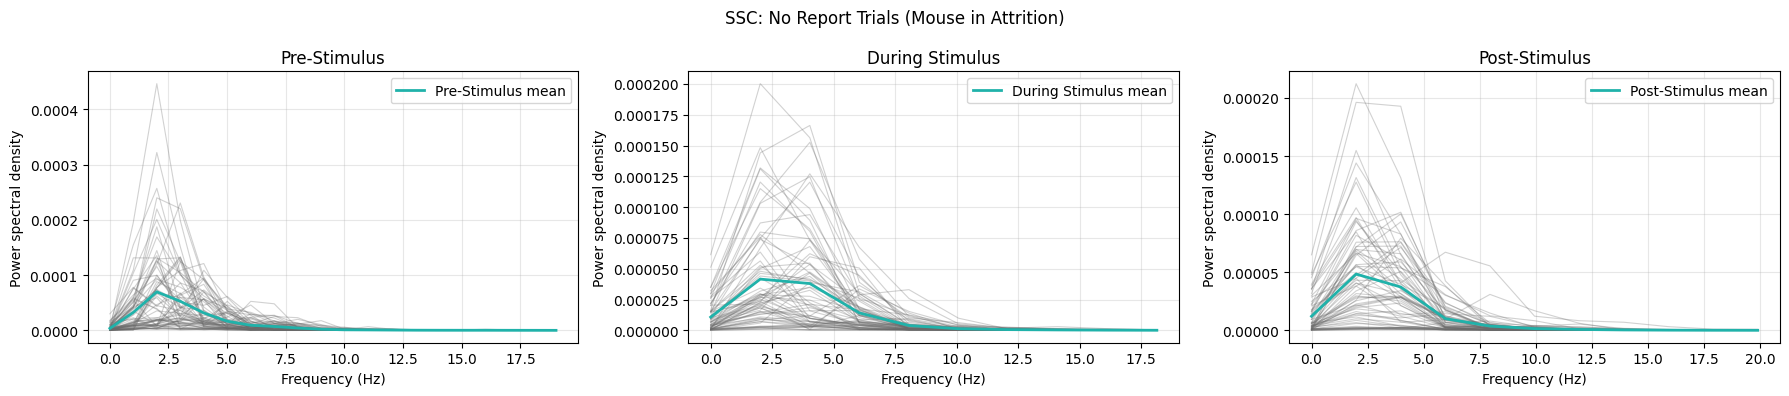

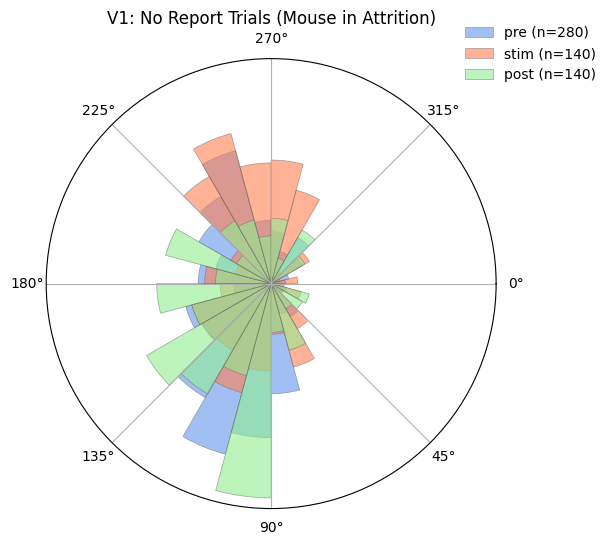

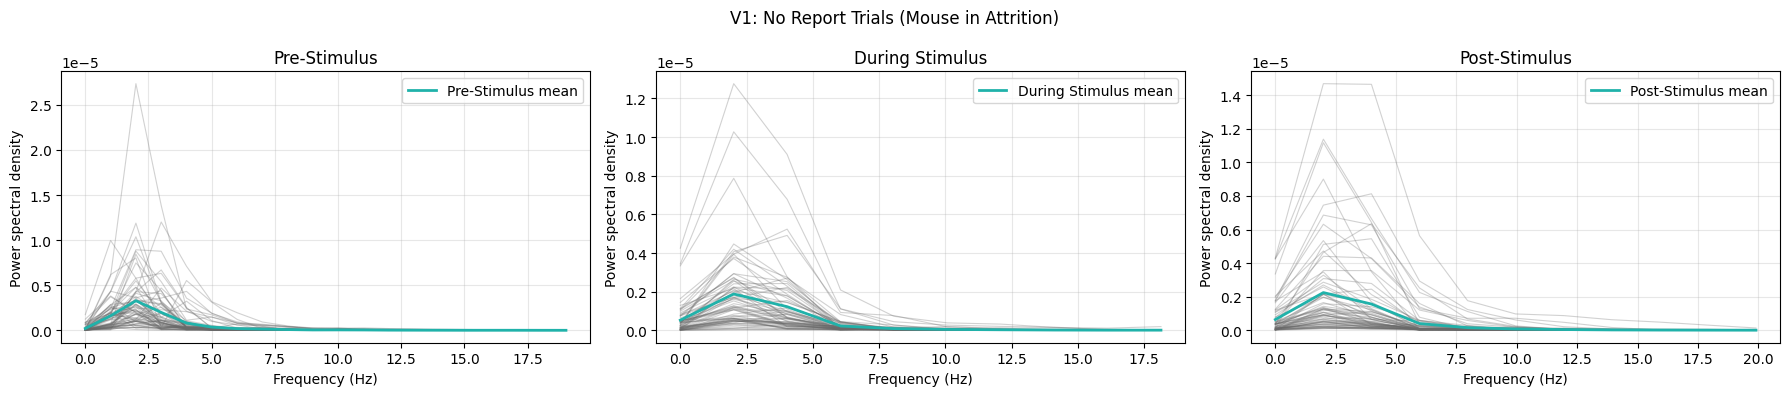

Found 23 trials.


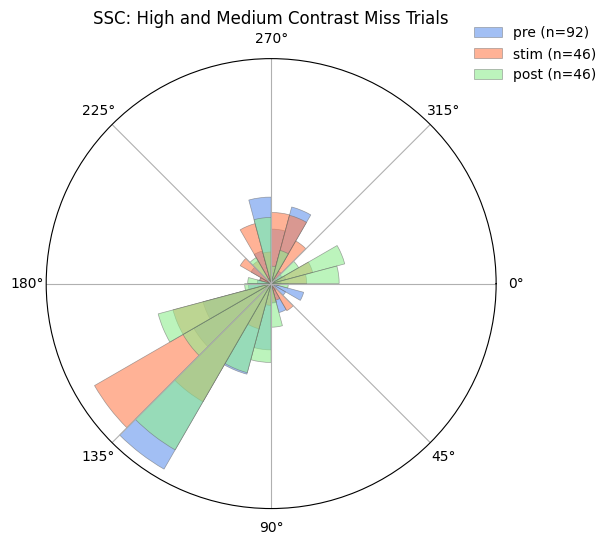

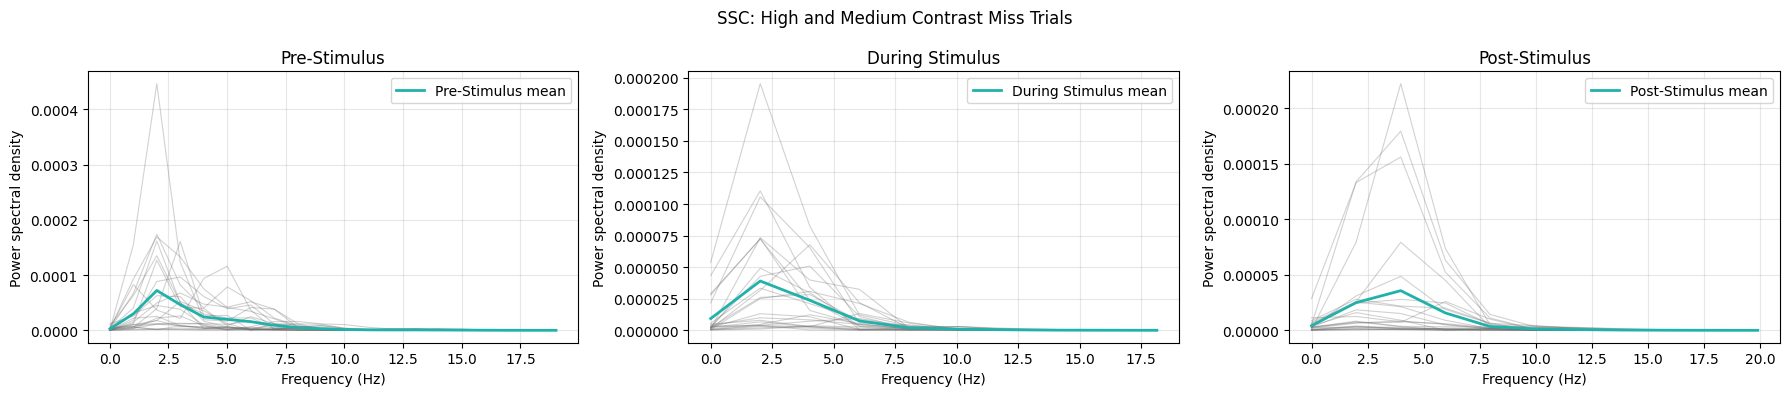

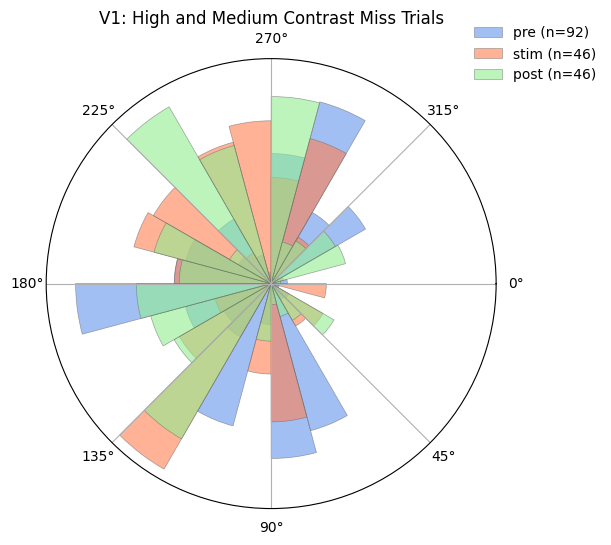

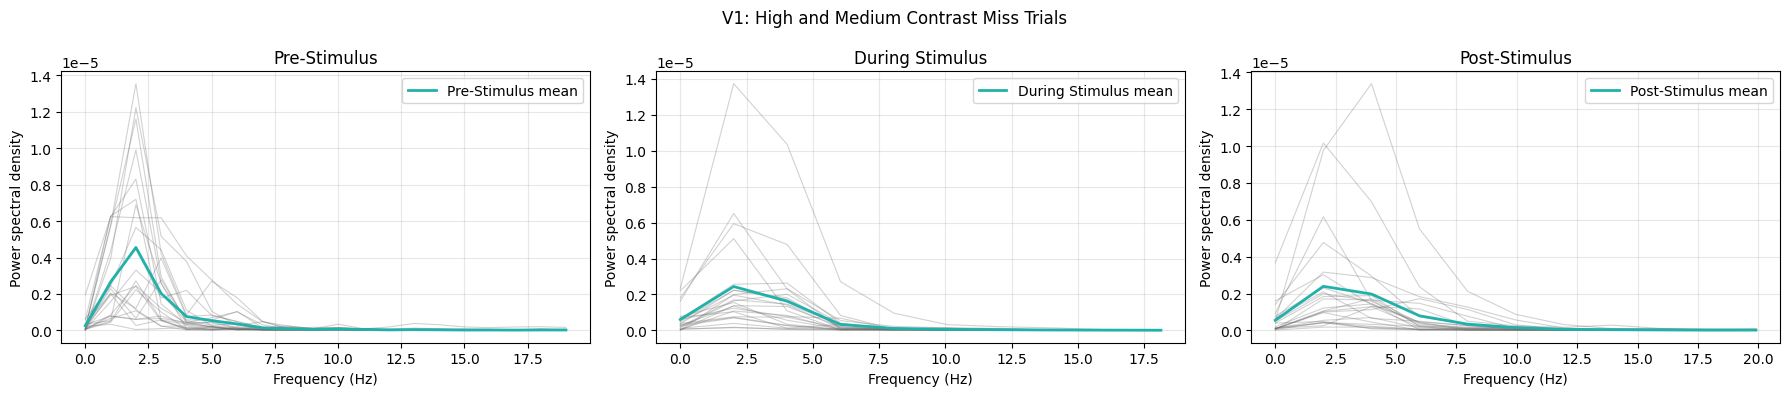

In [35]:
mouse = "cfm002mjr"
date = 240517
rec = 'meas01'

run_recording(mouse, date, rec, psd=True)

Running Recording cfm001mjr/240508
Found 25 trials.


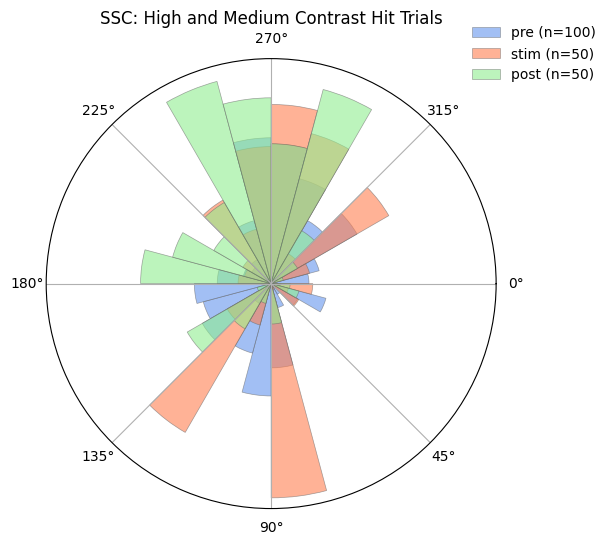

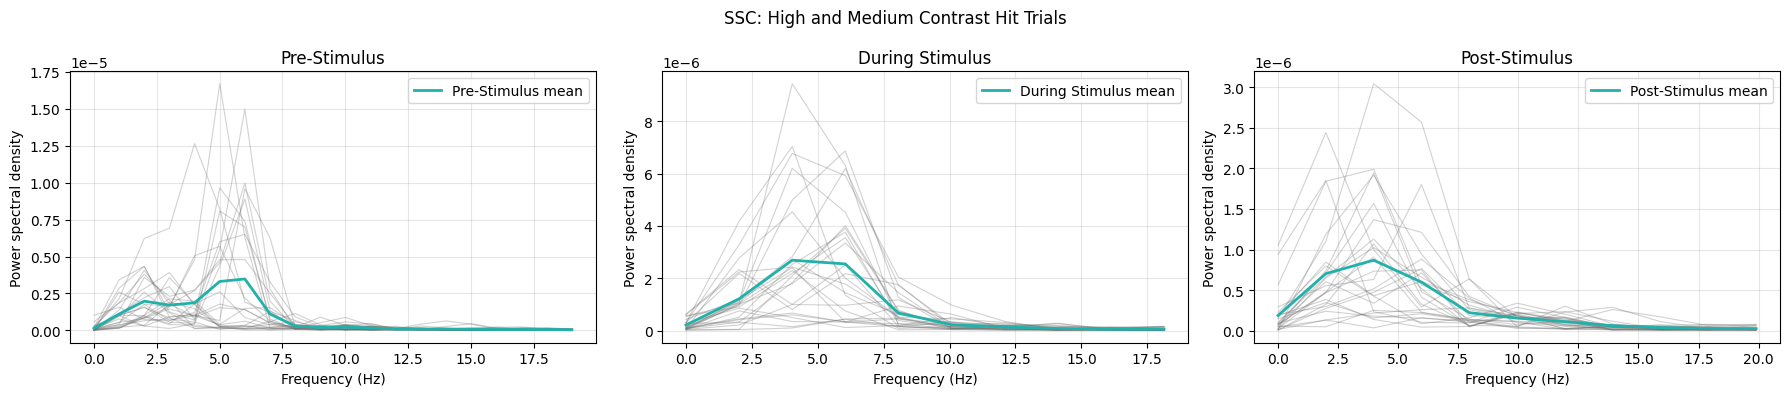

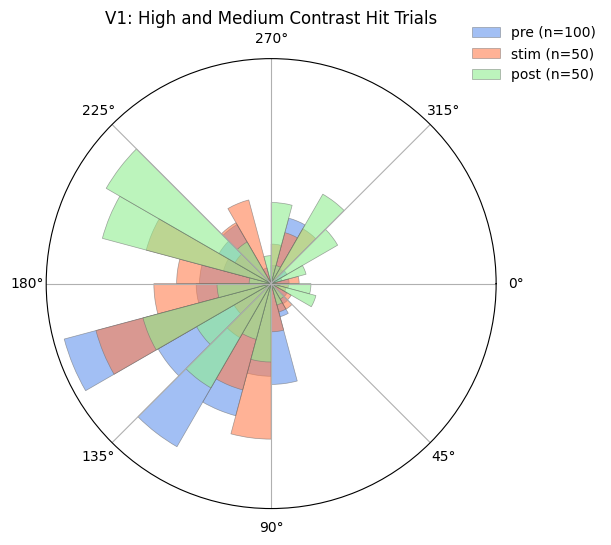

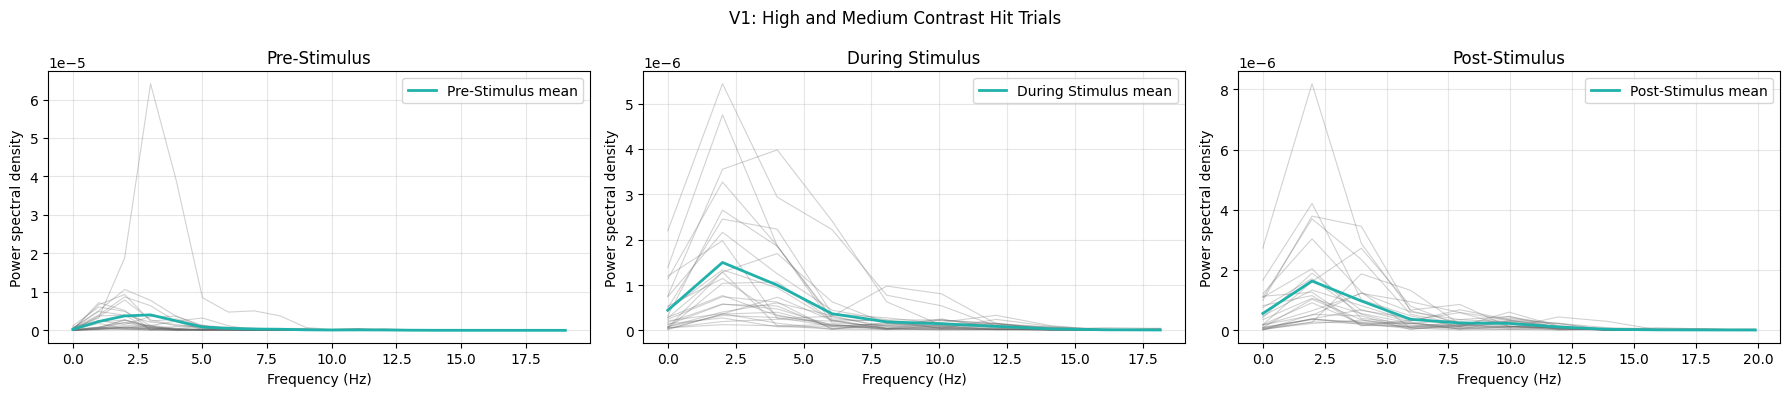

Found 119 trials.


C:\Users\Katie\AppData\Local\Temp\ipykernel_29612\1245933327.py:197: RuntimeWarning: invalid value encountered in scalar divide
  mx = np.sum(wx) / denom
C:\Users\Katie\AppData\Local\Temp\ipykernel_29612\1245933327.py:198: RuntimeWarning: invalid value encountered in scalar divide
  my = np.sum(wy) / denom


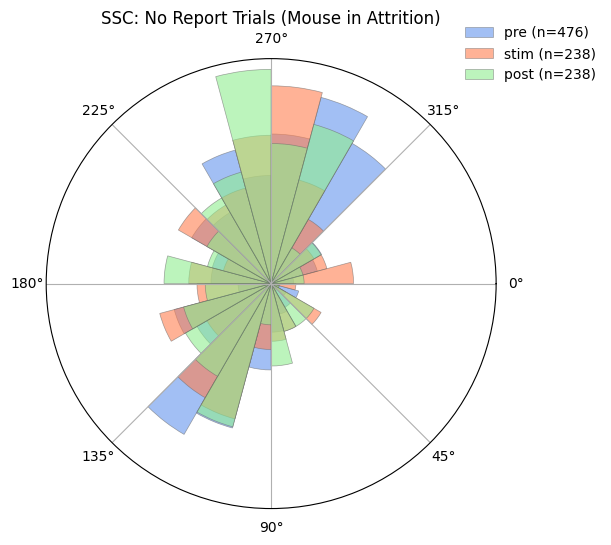

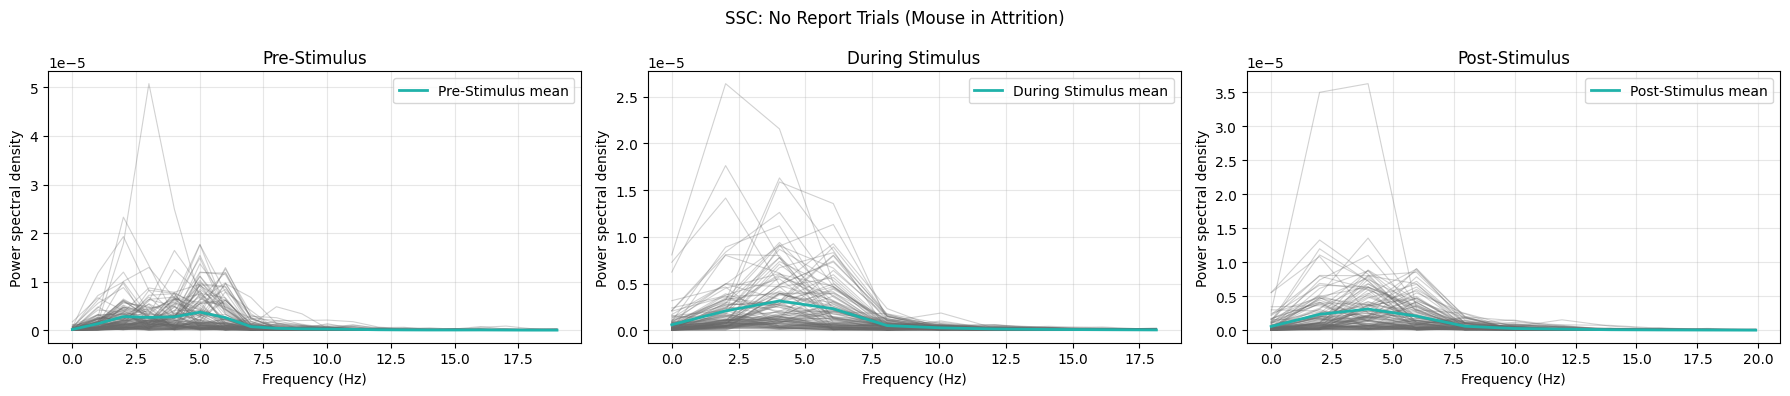

C:\Users\Katie\AppData\Local\Temp\ipykernel_29612\1245933327.py:197: RuntimeWarning: invalid value encountered in scalar divide
  mx = np.sum(wx) / denom
C:\Users\Katie\AppData\Local\Temp\ipykernel_29612\1245933327.py:198: RuntimeWarning: invalid value encountered in scalar divide
  my = np.sum(wy) / denom


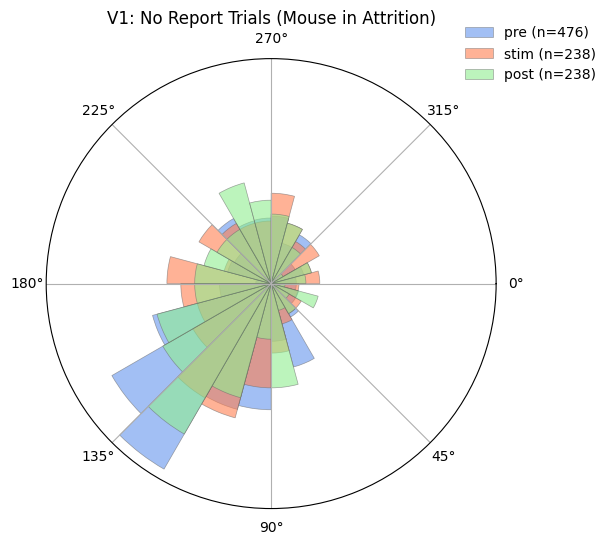

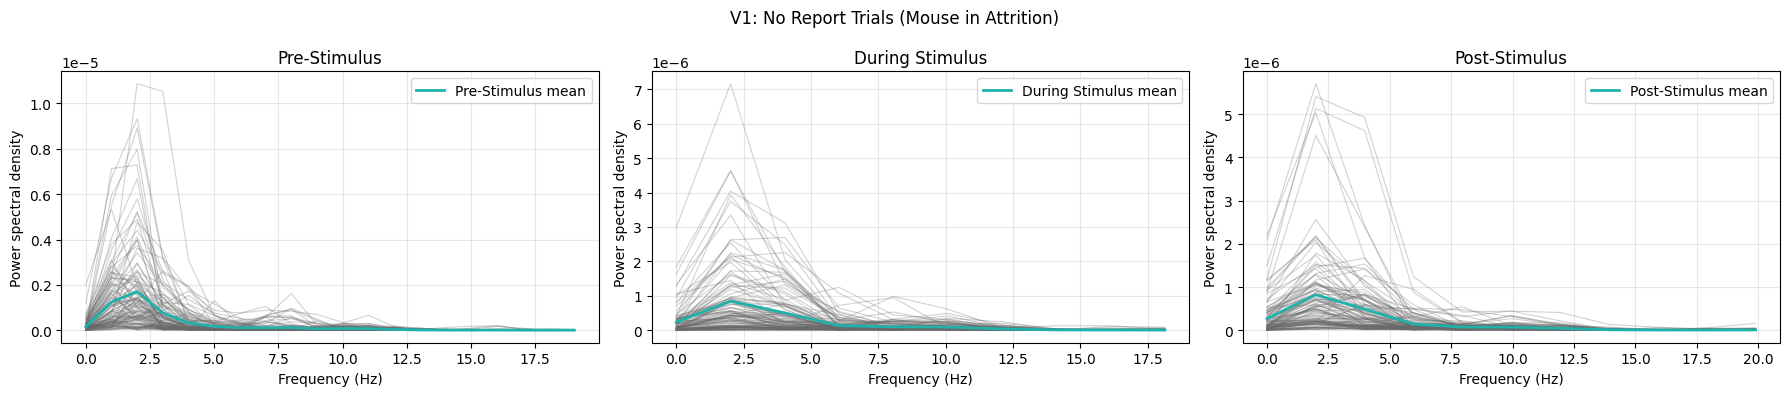

Found 18 trials.


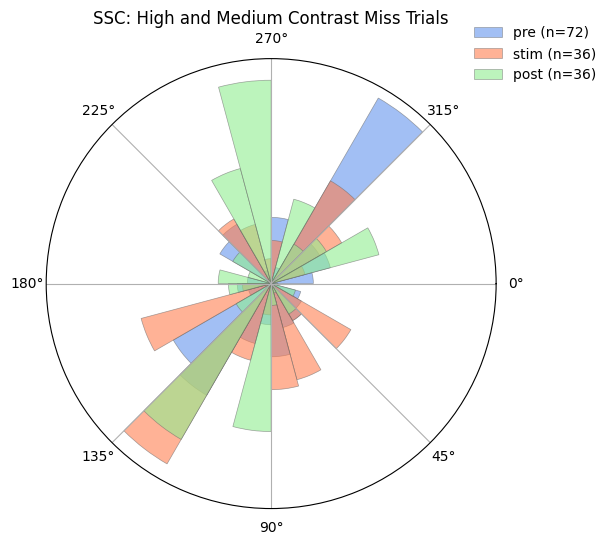

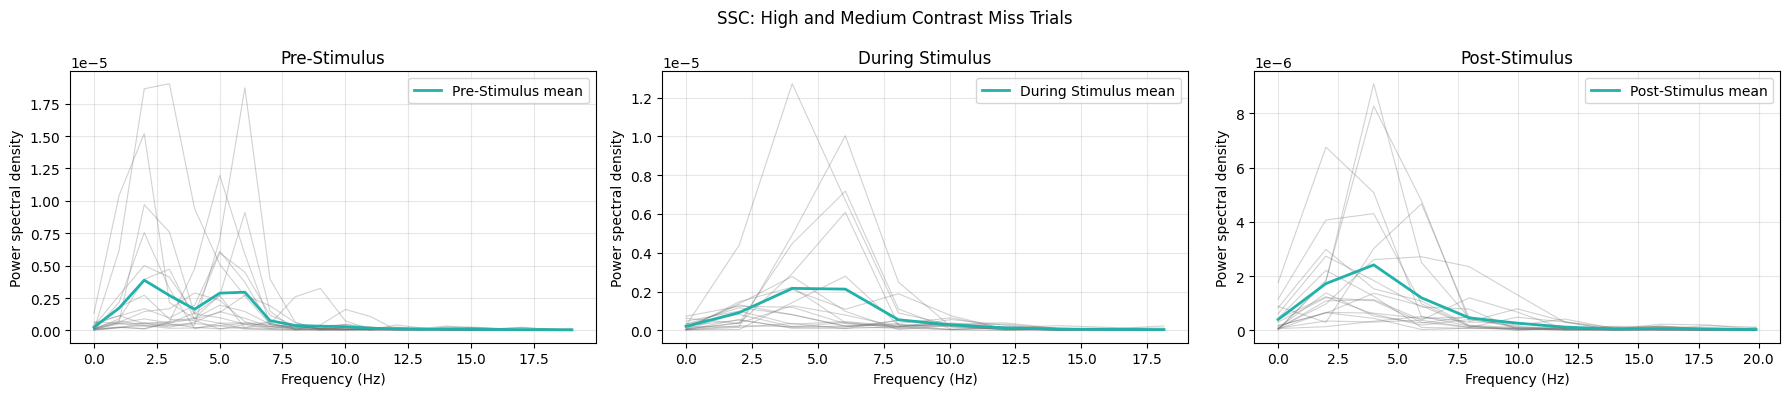

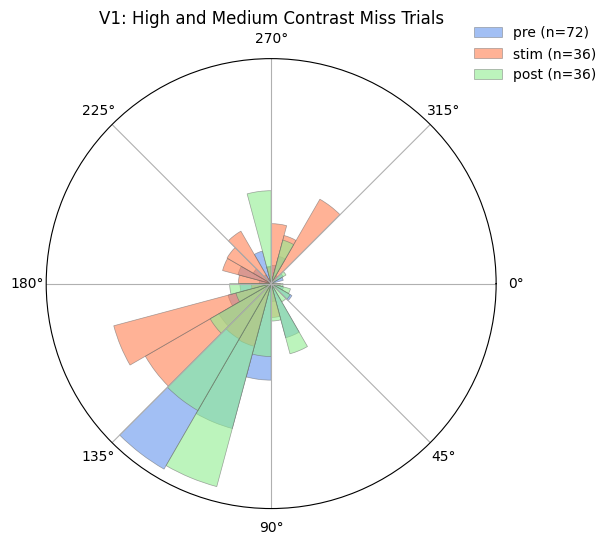

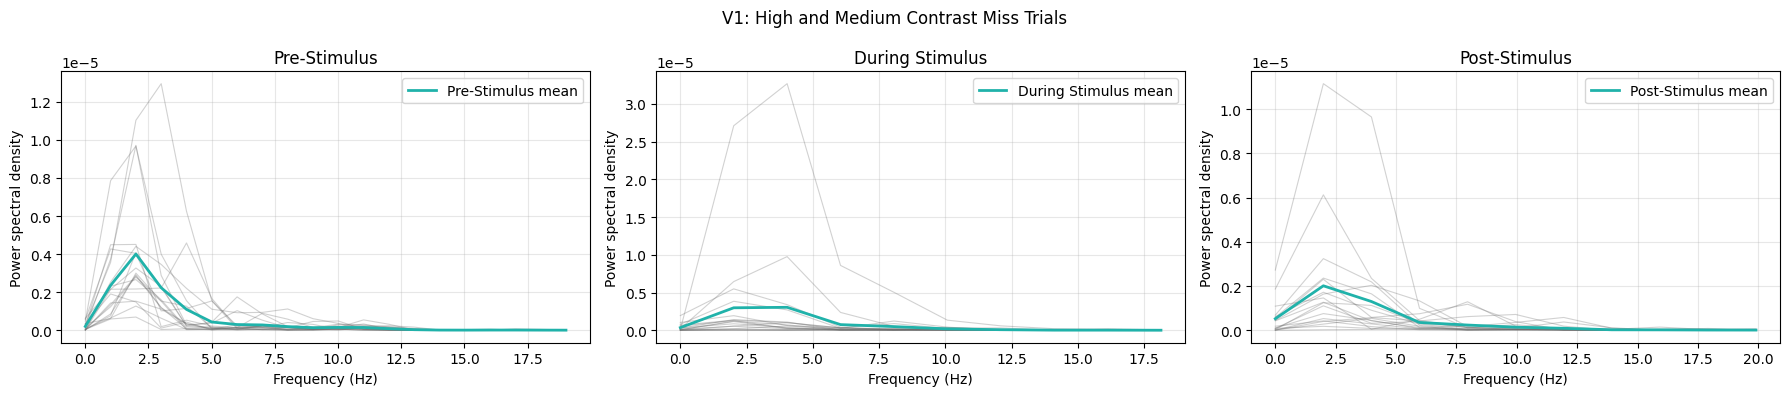

Running Recording cfm002mjr/240514
Found 31 trials.


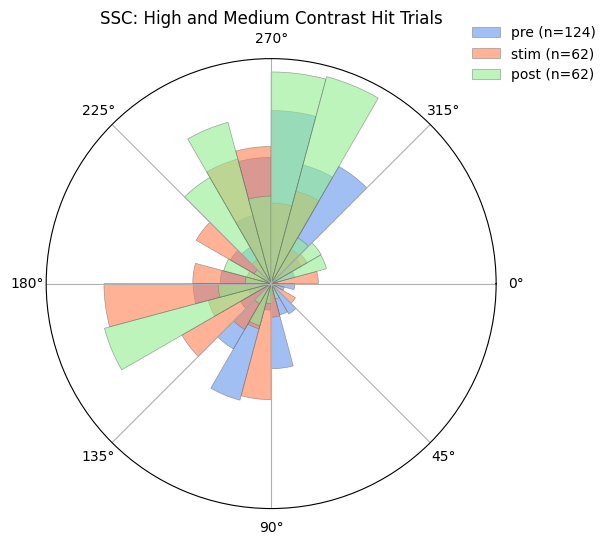

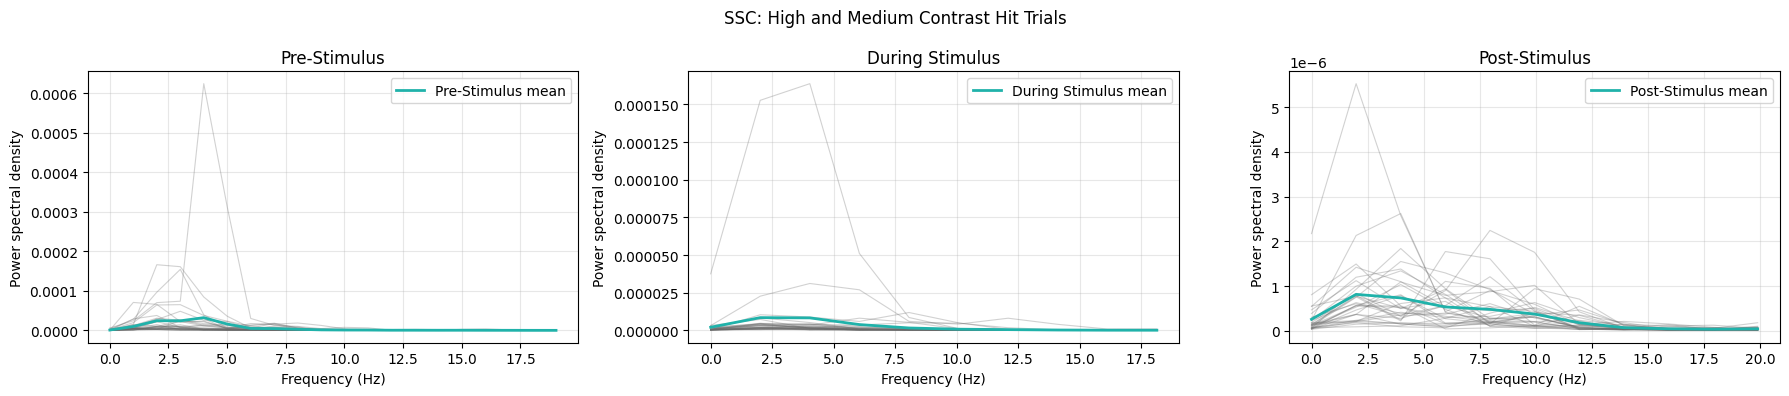

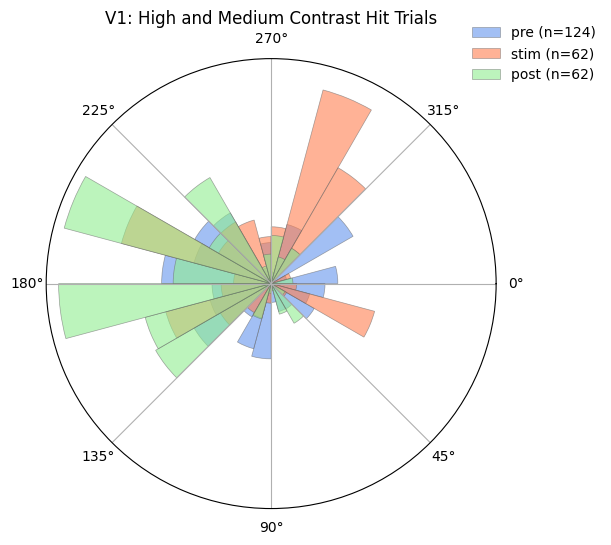

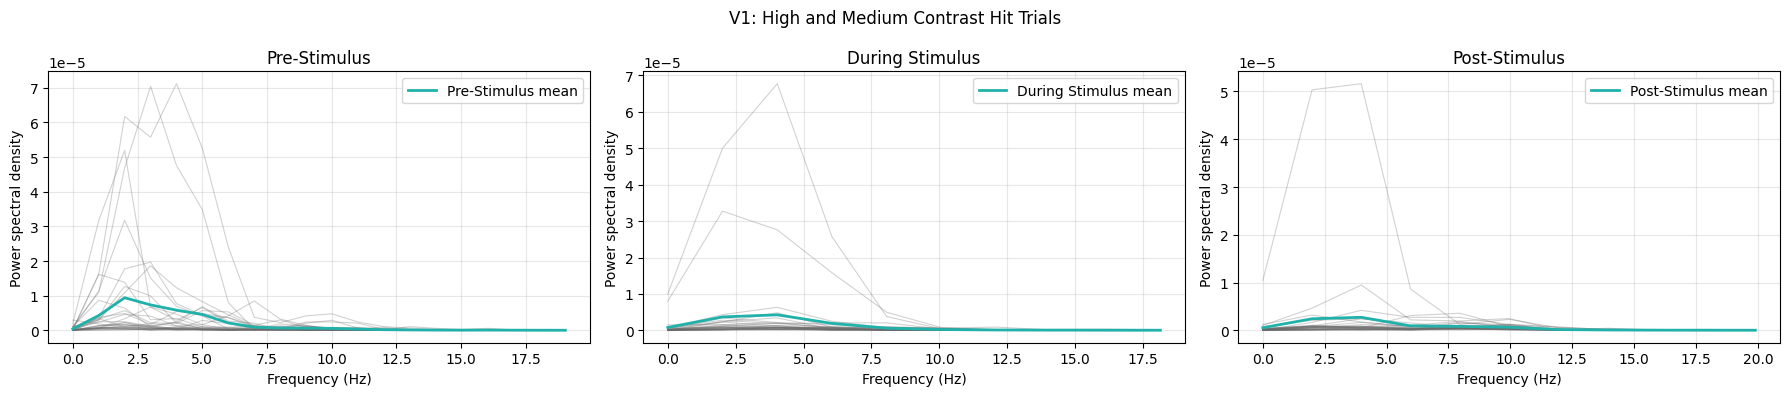

Found 160 trials.


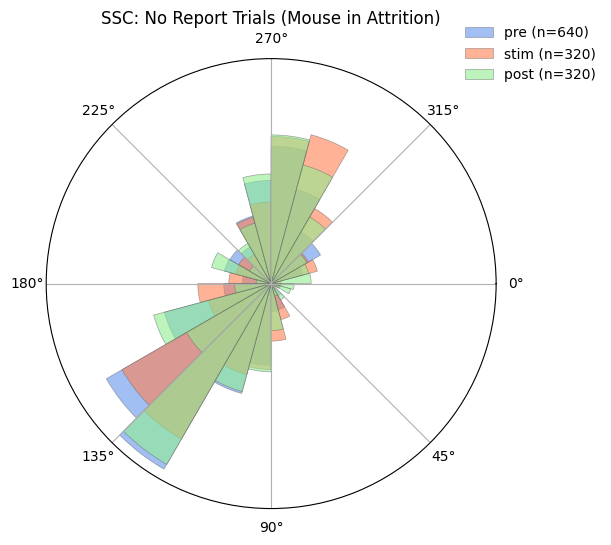

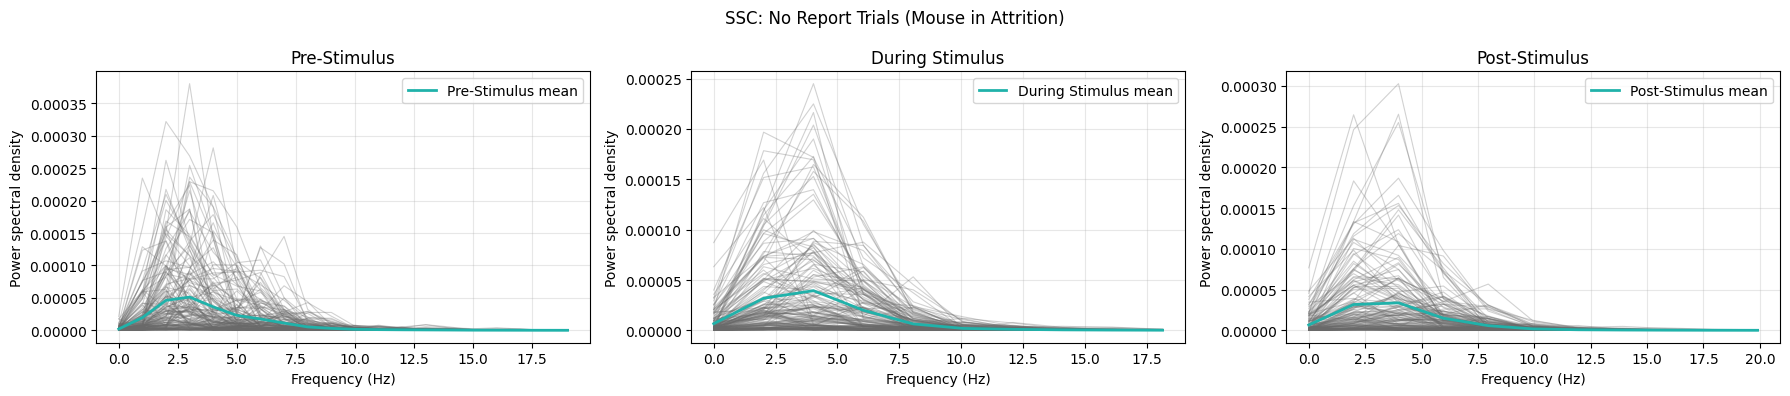

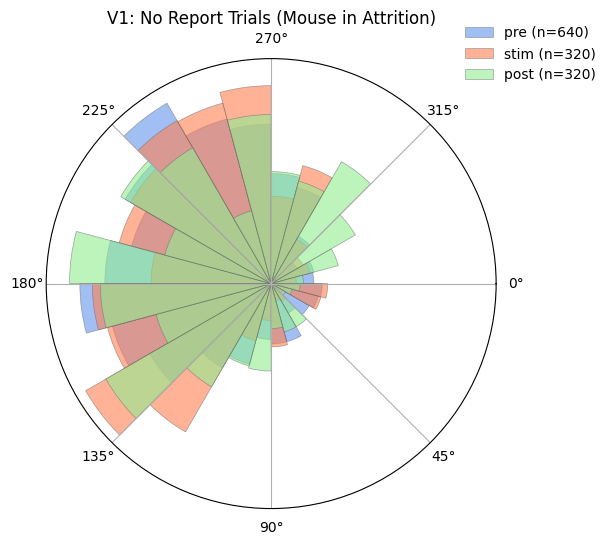

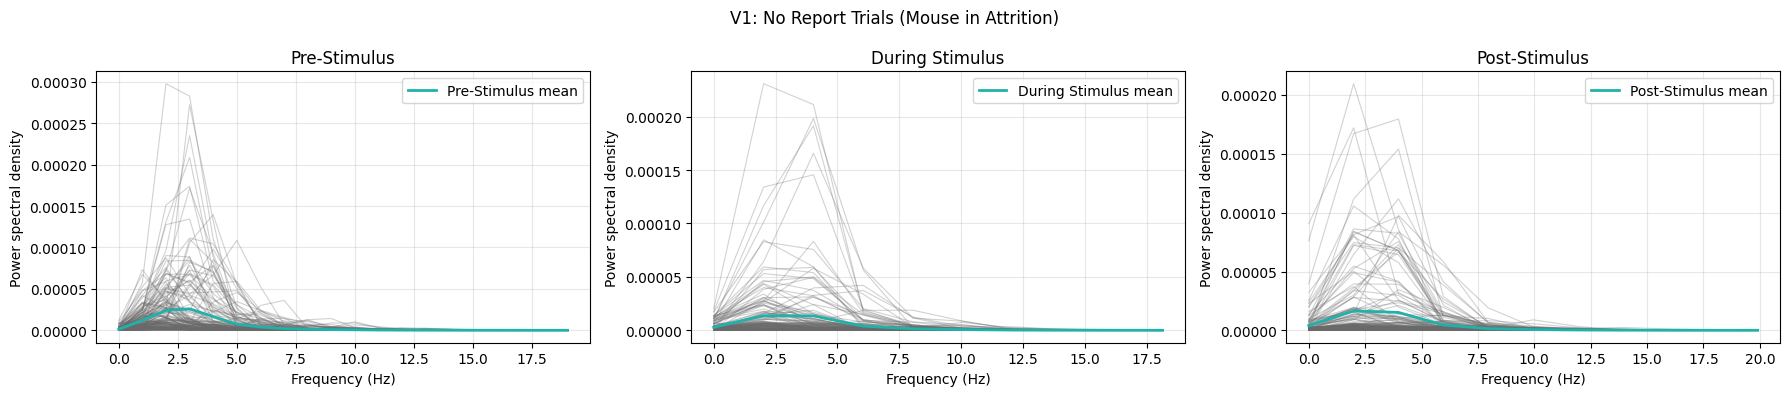

Found 30 trials.


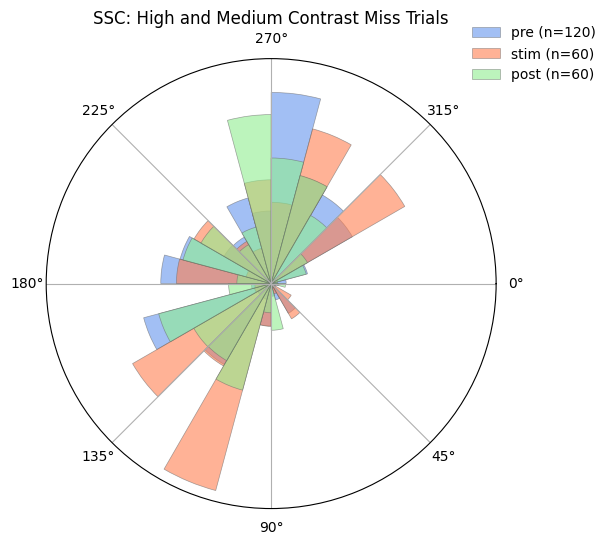

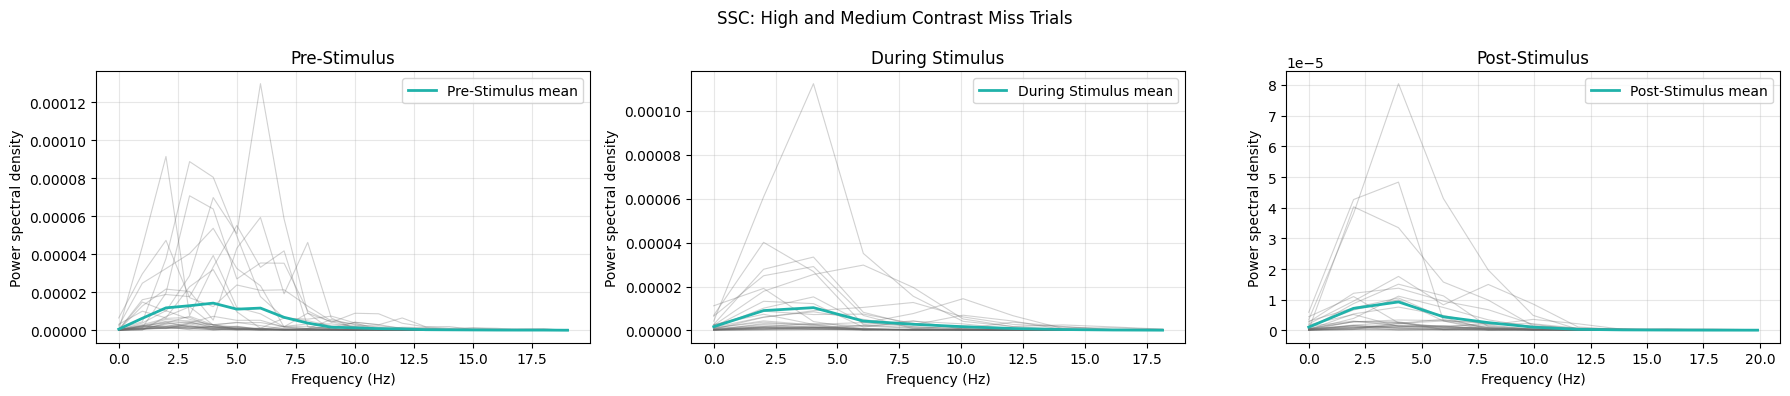

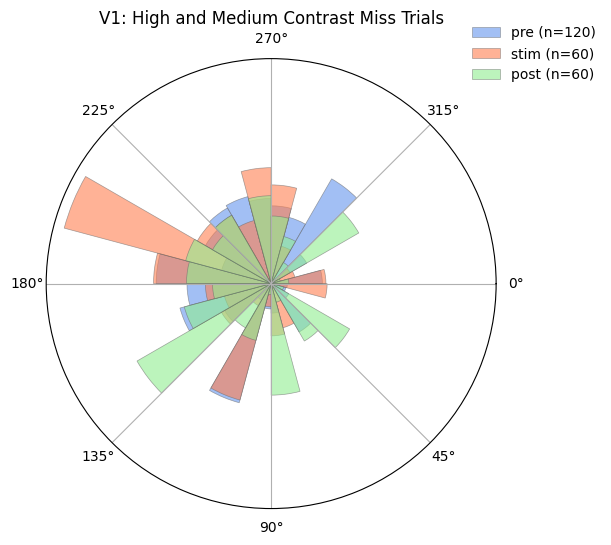

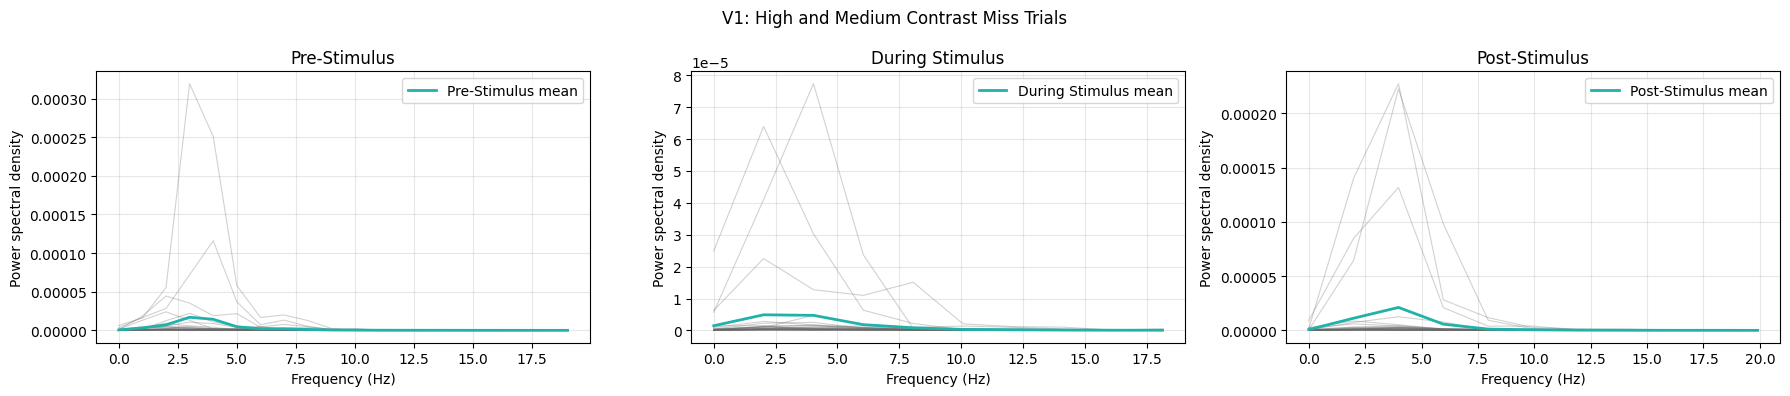

Running Recording cfm002mjr/240516
Found 48 trials.


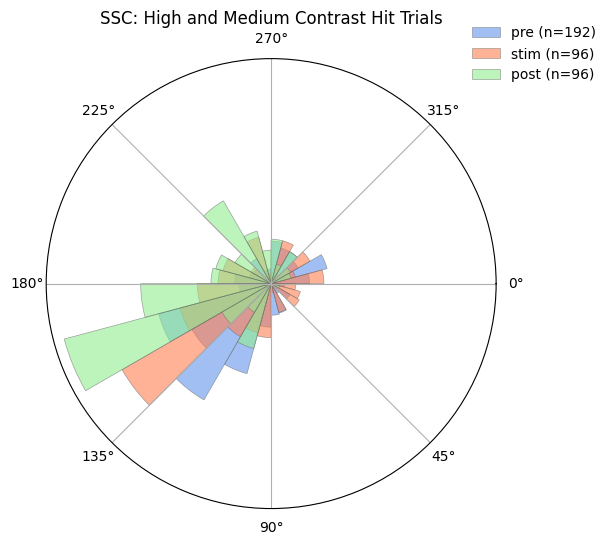

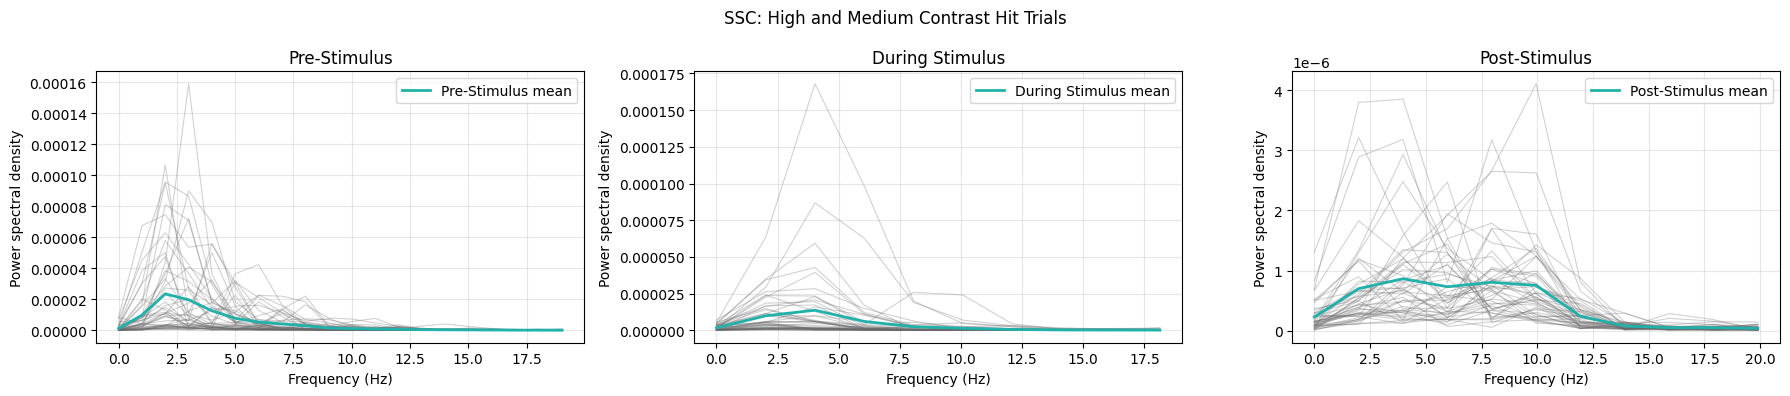

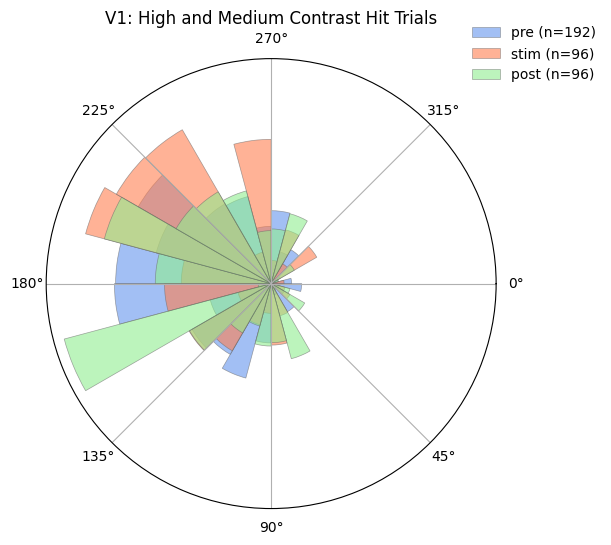

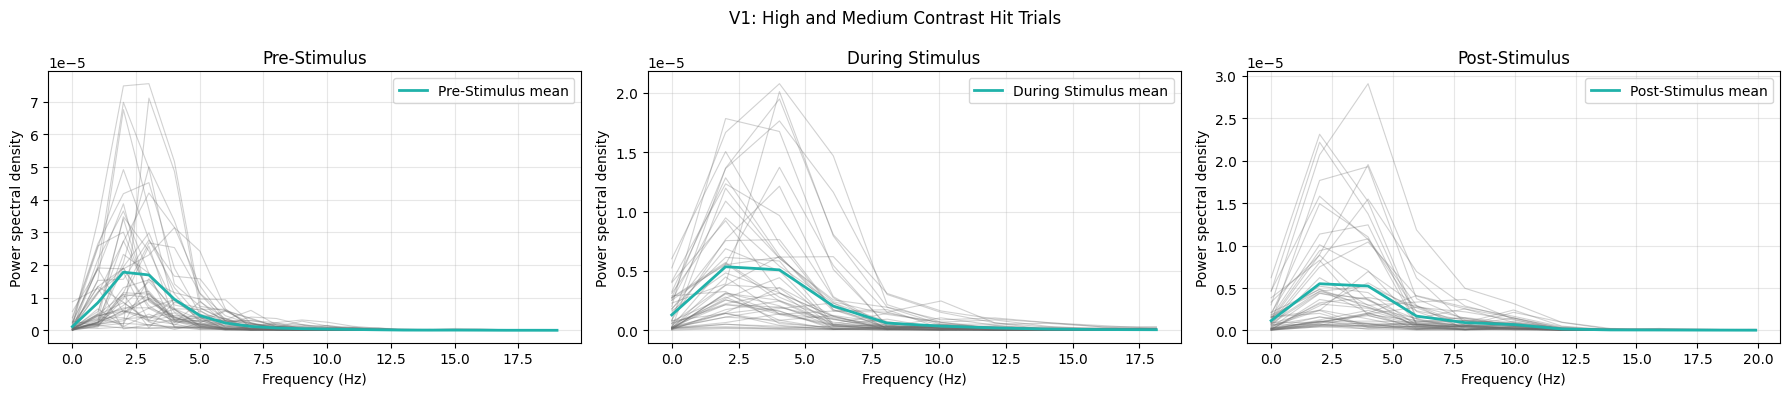

Found 123 trials.


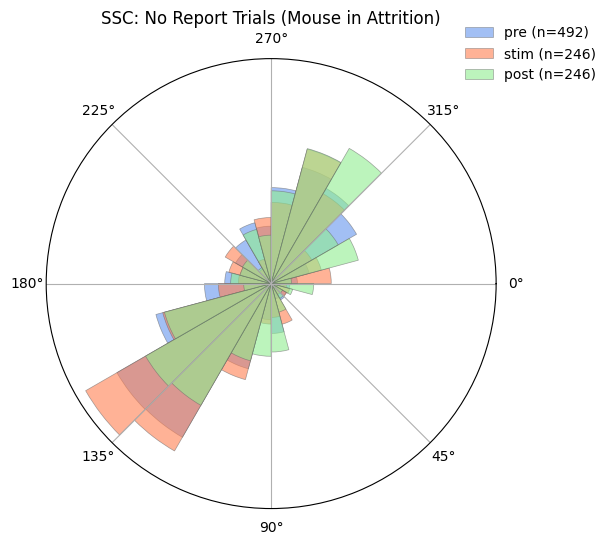

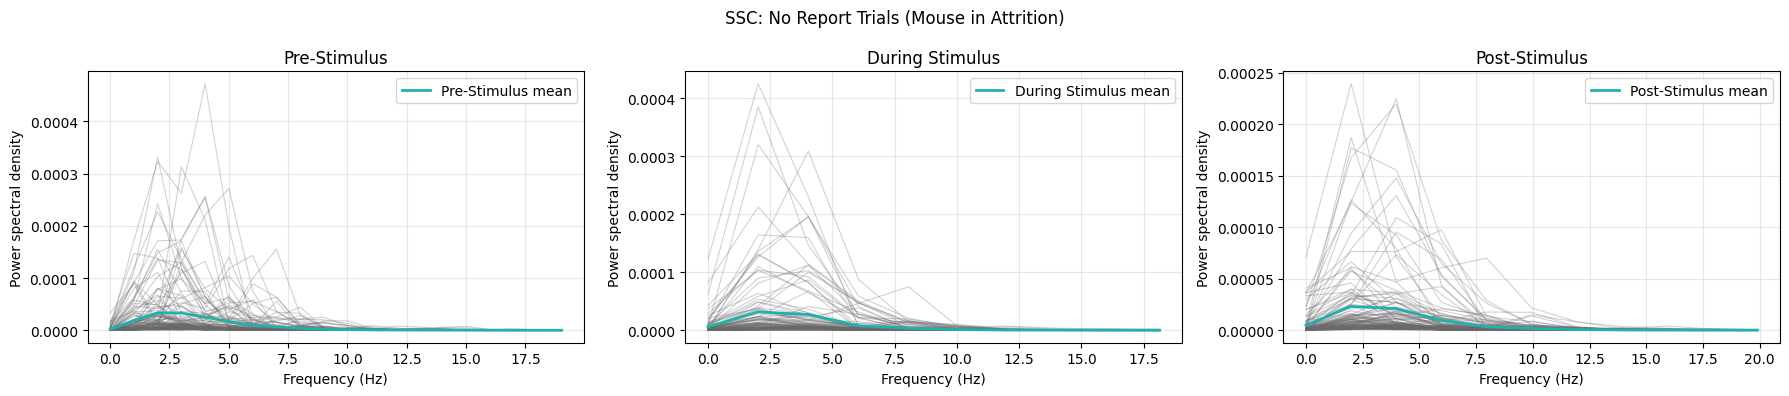

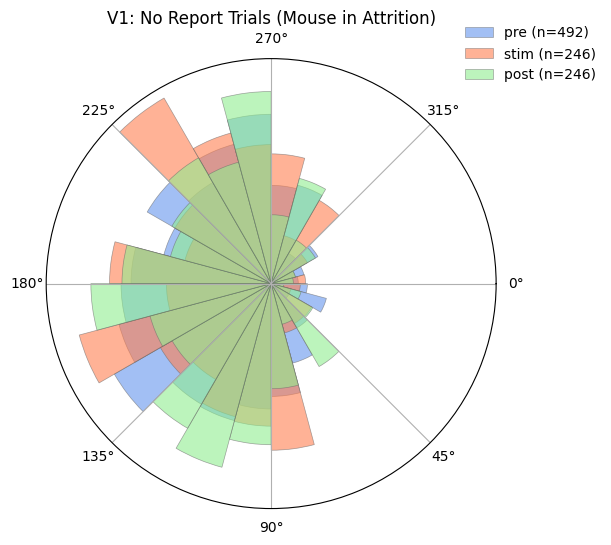

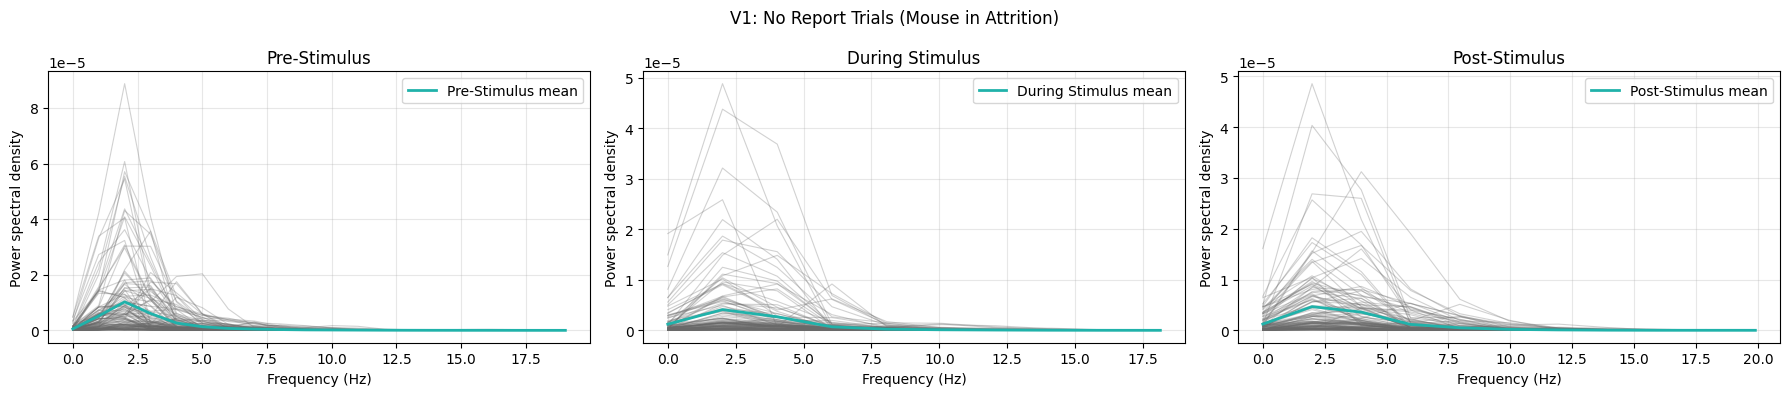

Found 36 trials.
Invalid number of FFT data points (0) specified.


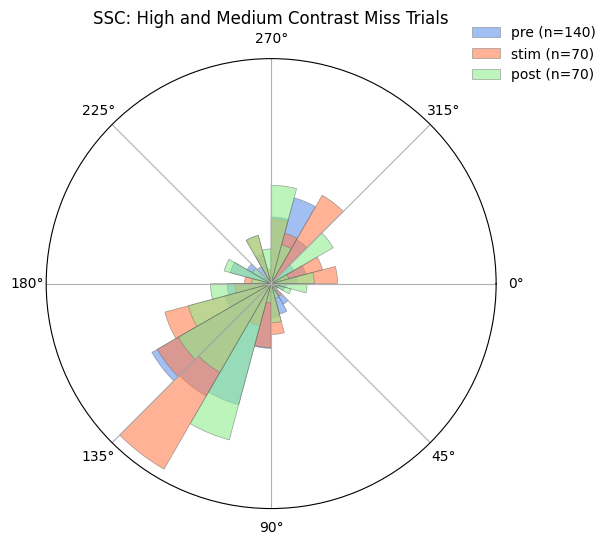

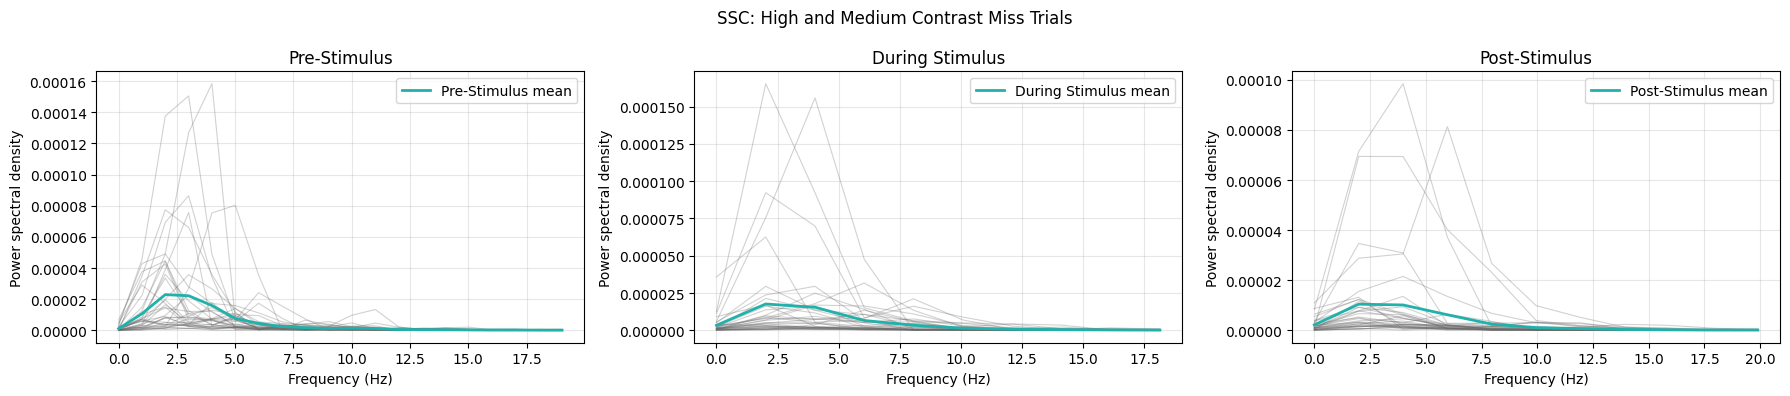

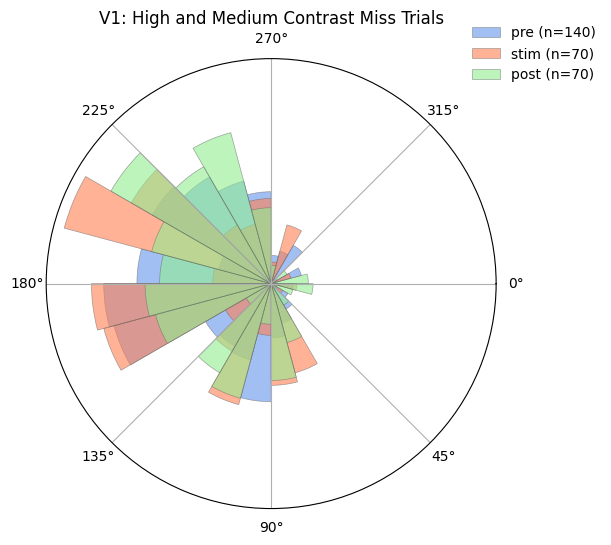

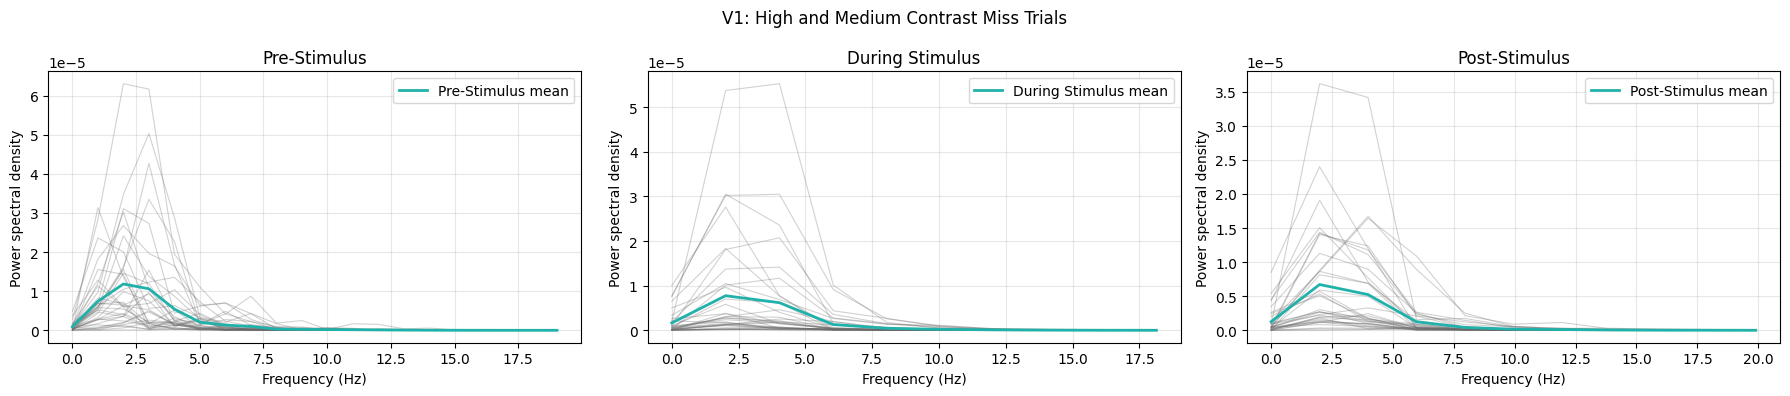

Running Recording cfm002mjr/240517
Found 22 trials.


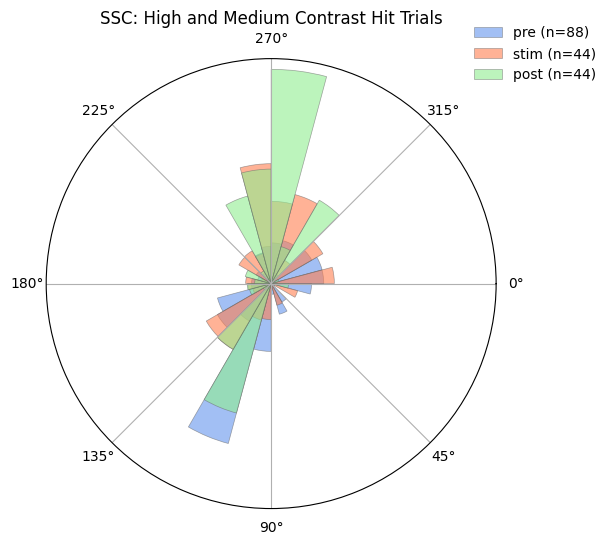

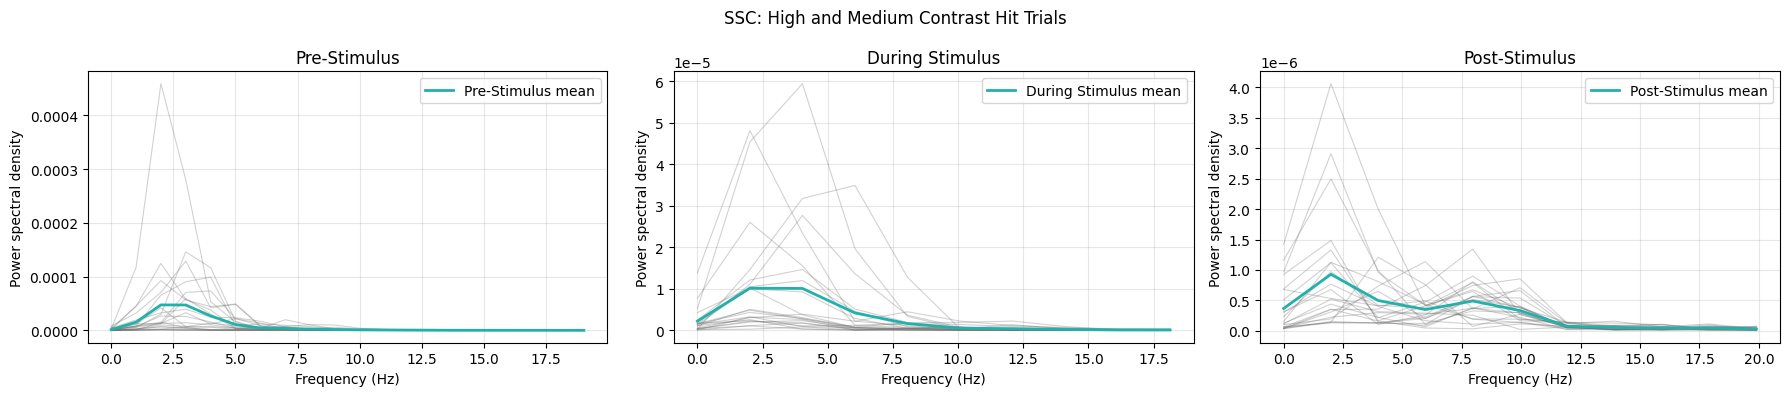

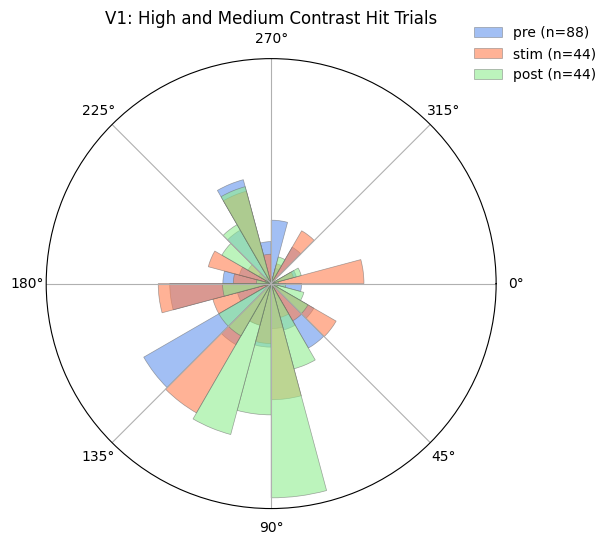

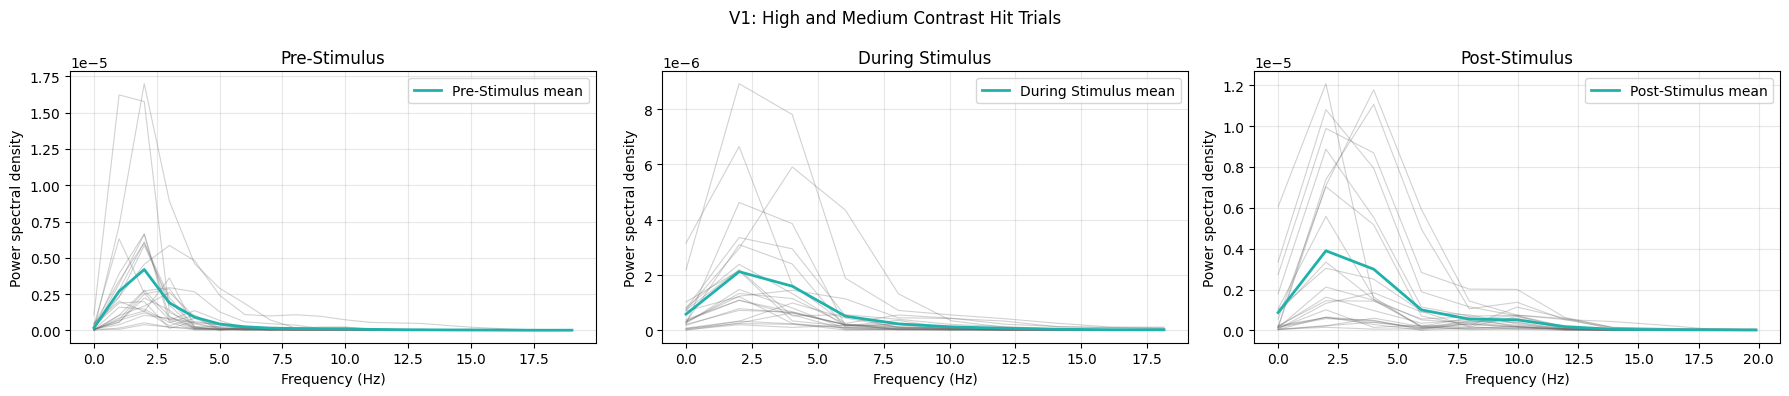

Found 150 trials.


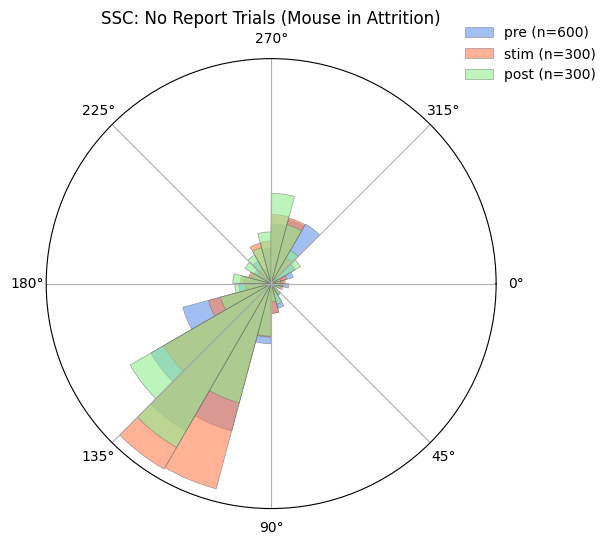

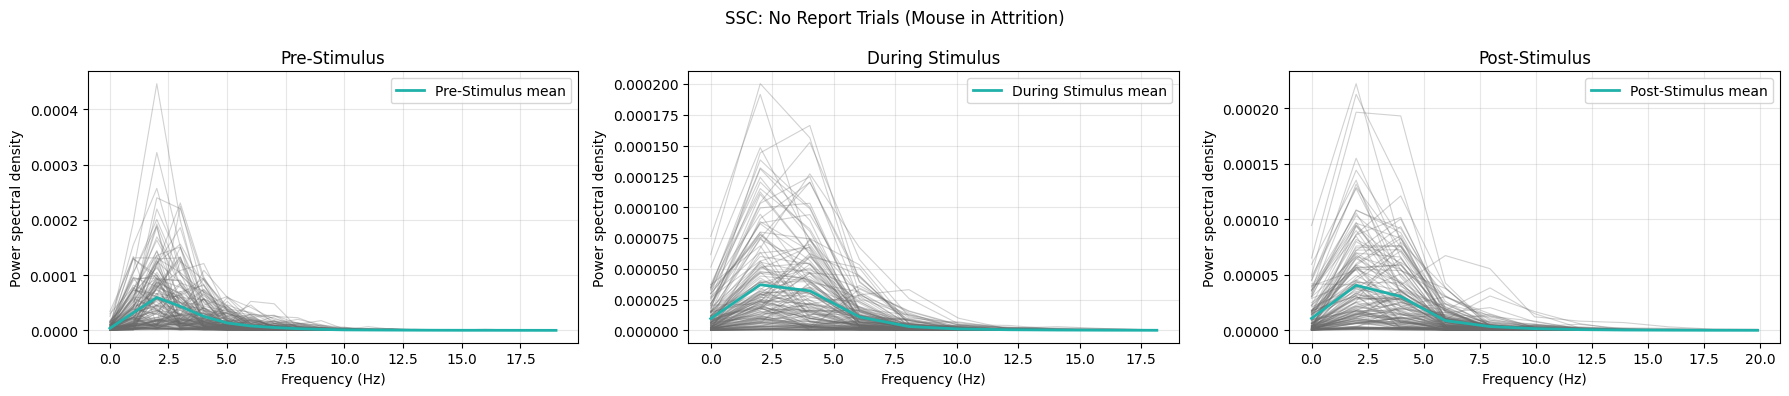

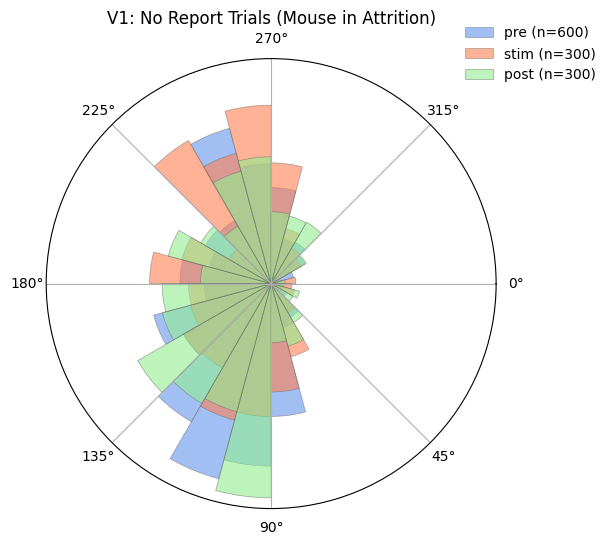

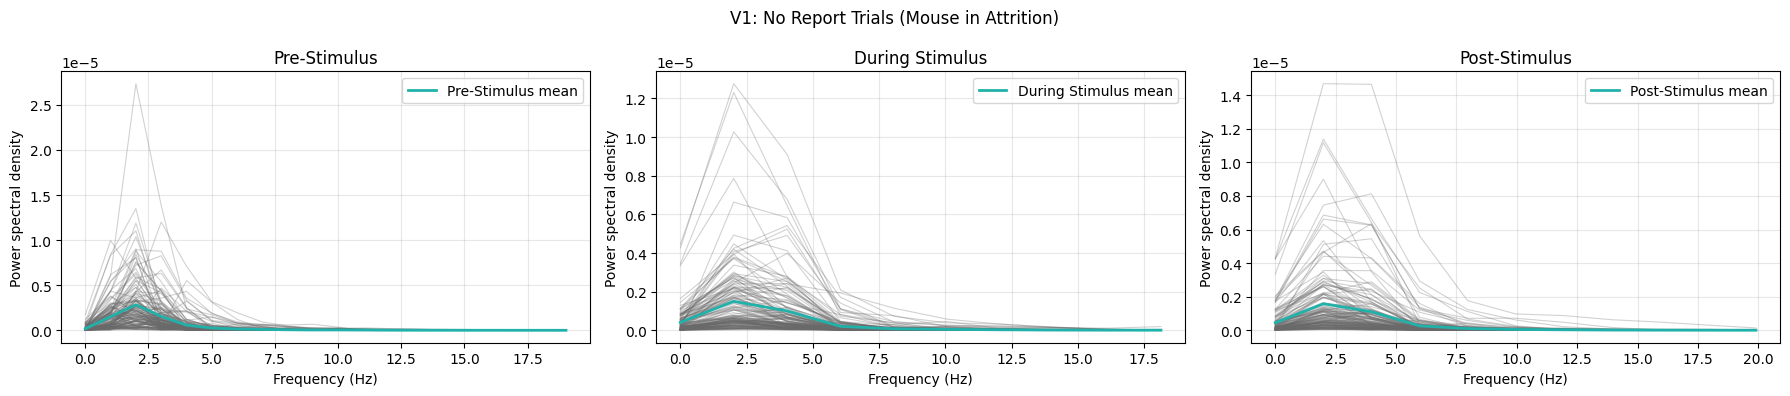

Found 40 trials.


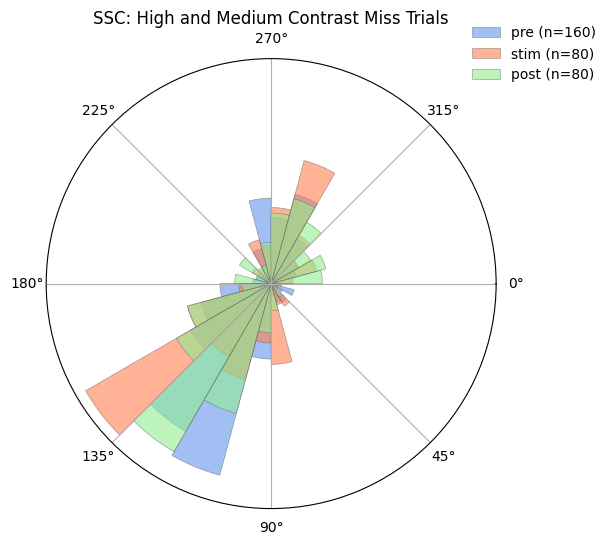

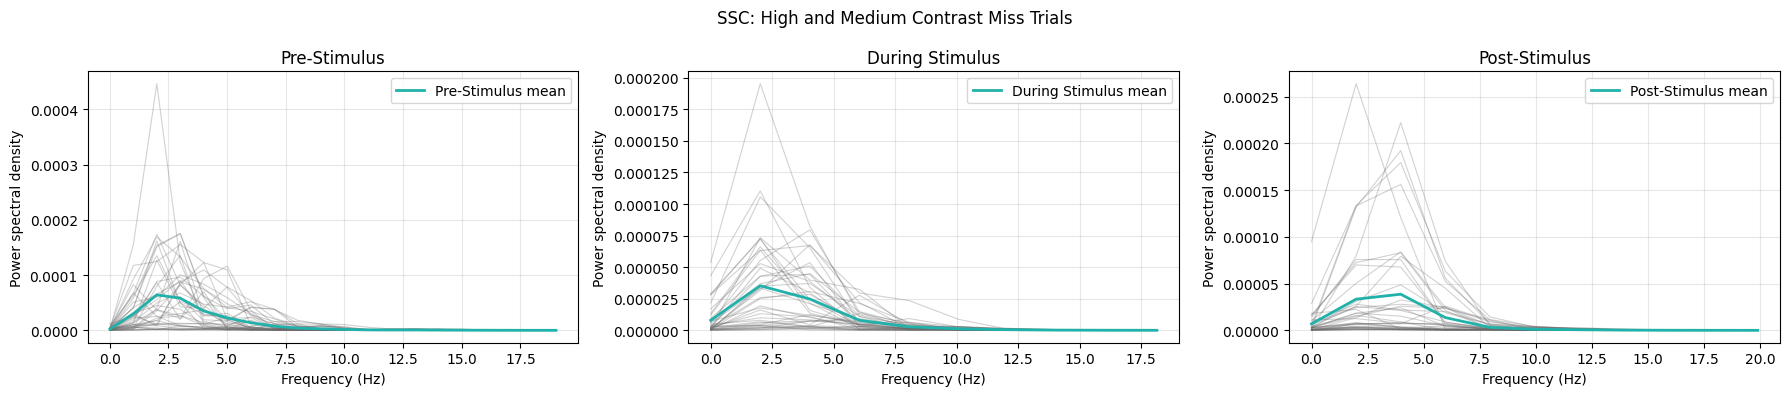

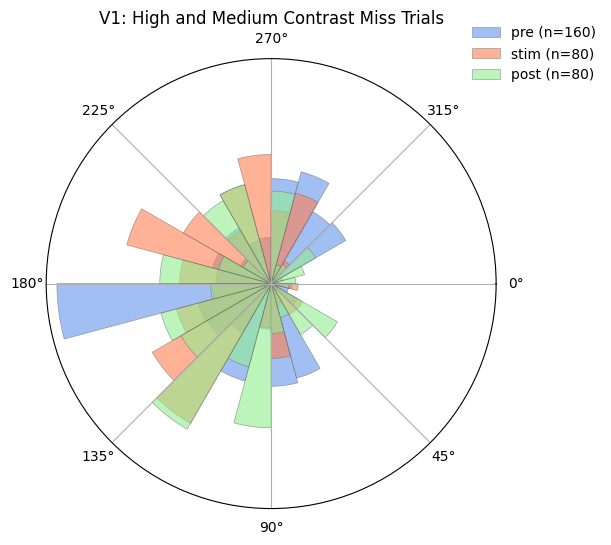

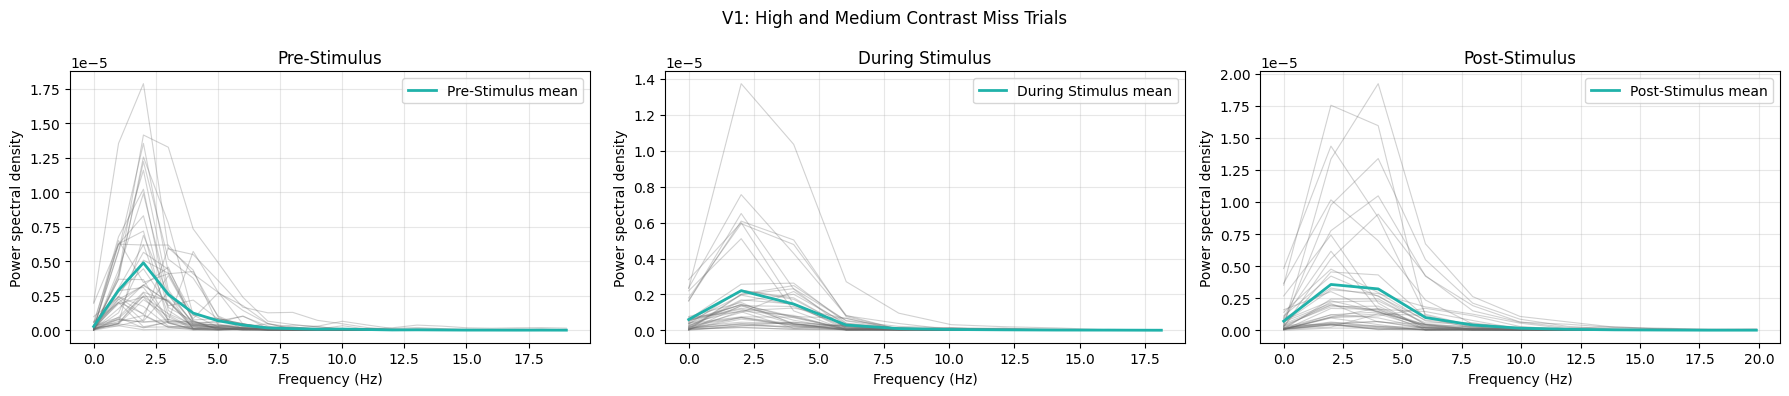

Running Recording cfm003mjr/240513
Found 55 trials.


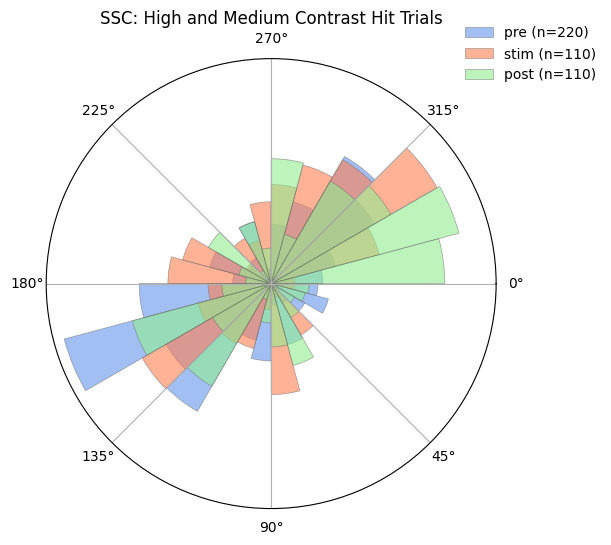

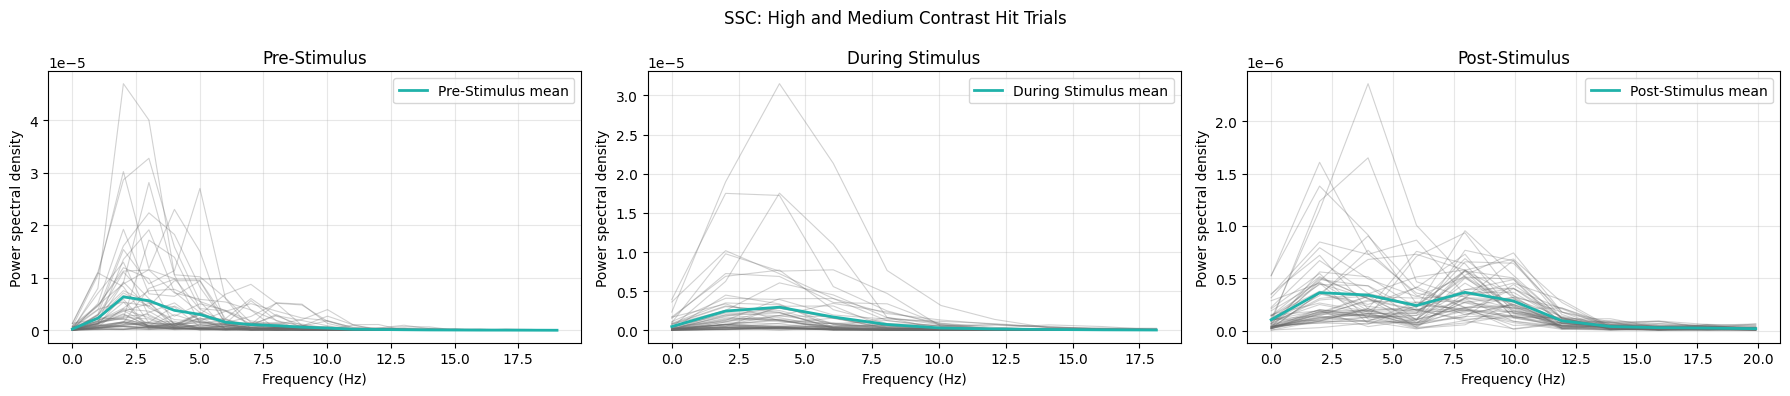

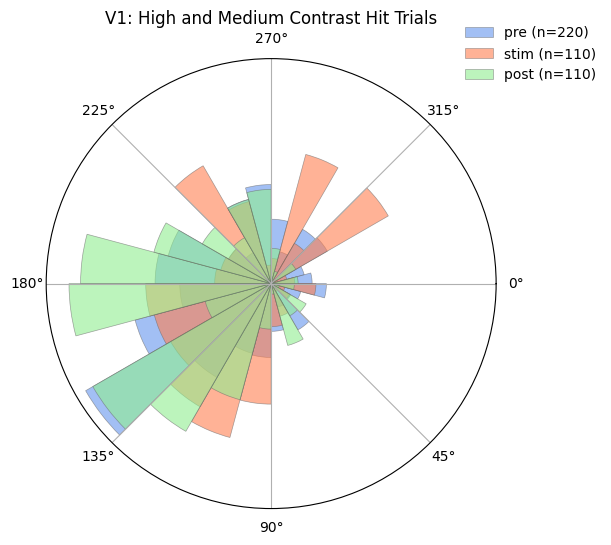

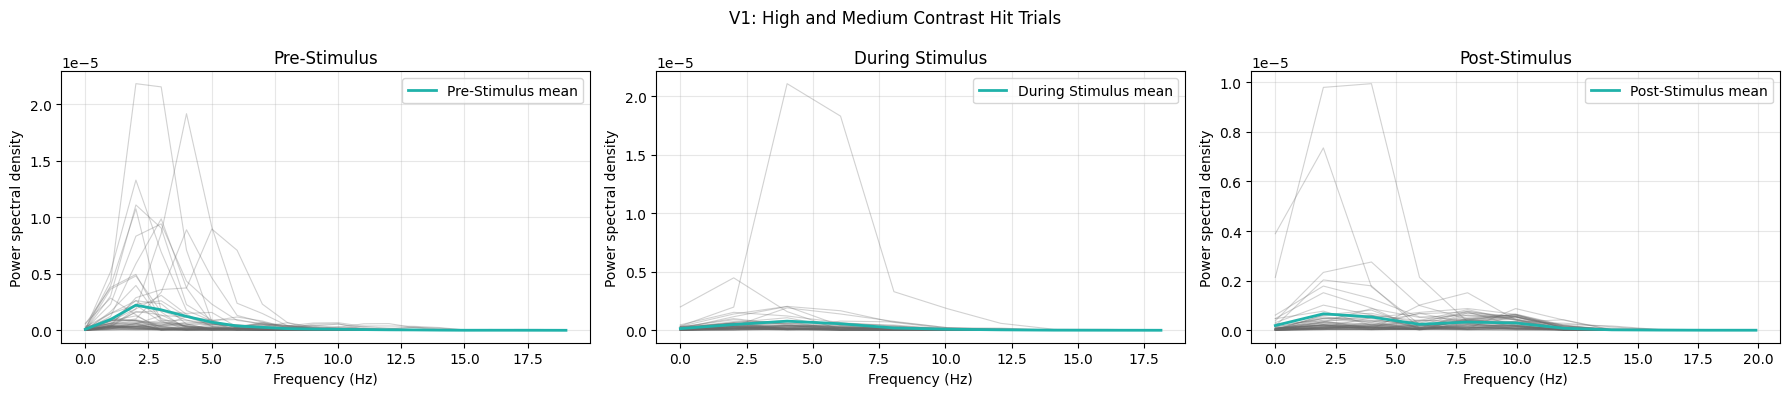

Found 133 trials.


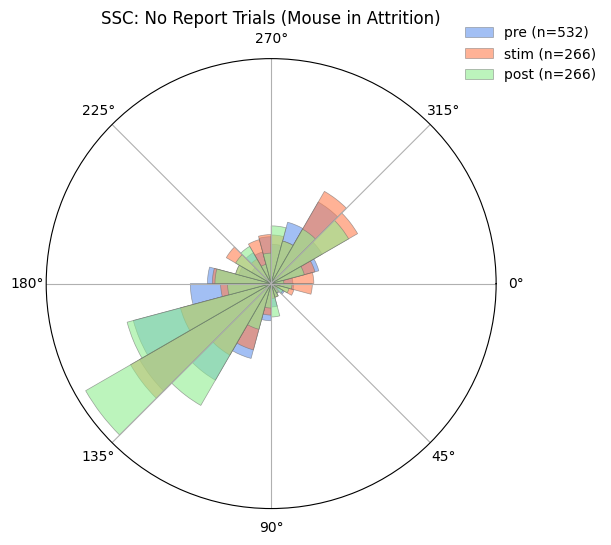

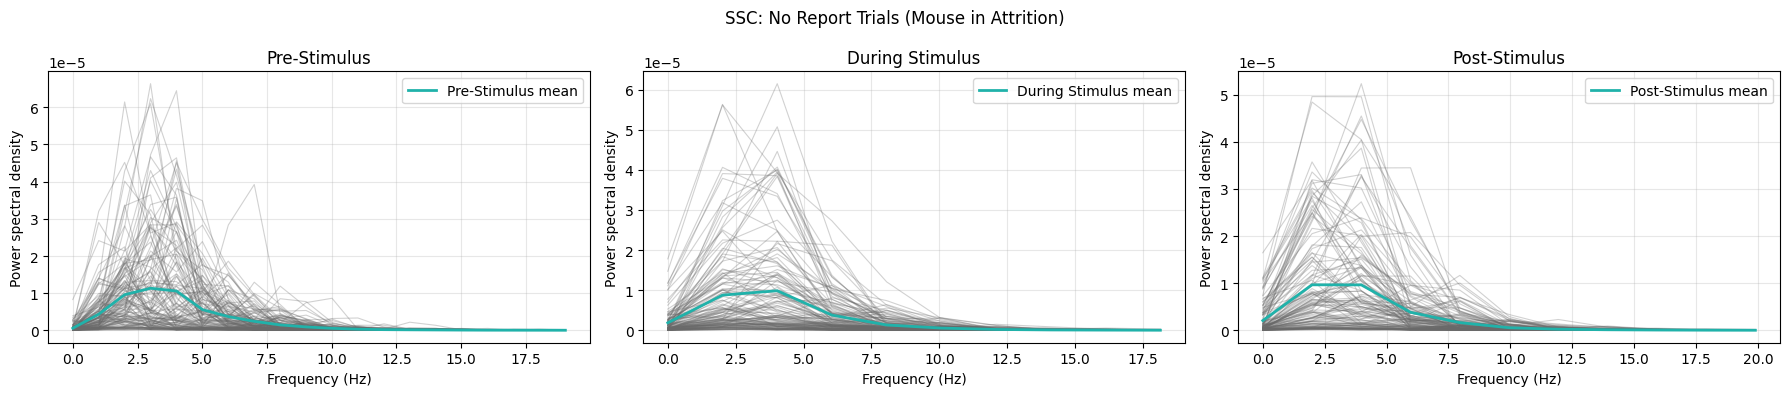

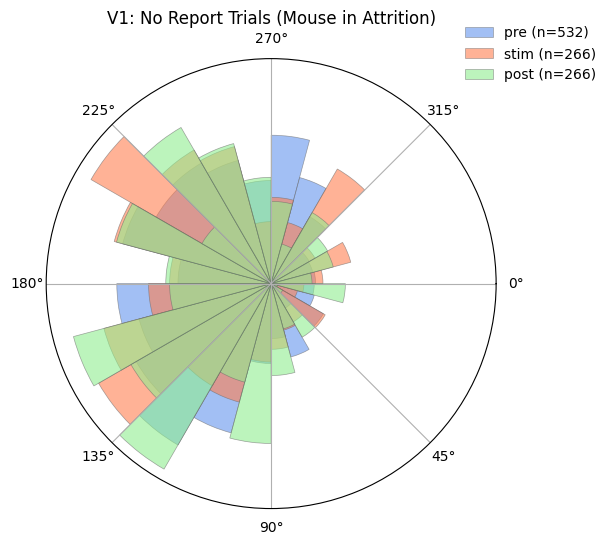

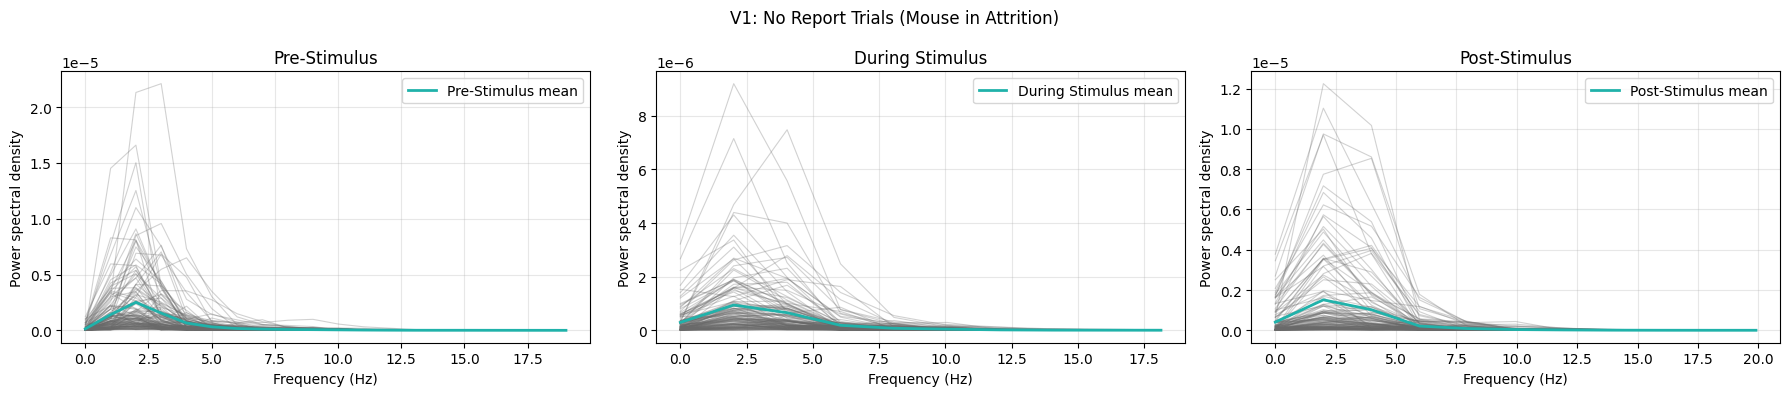

Found 45 trials.


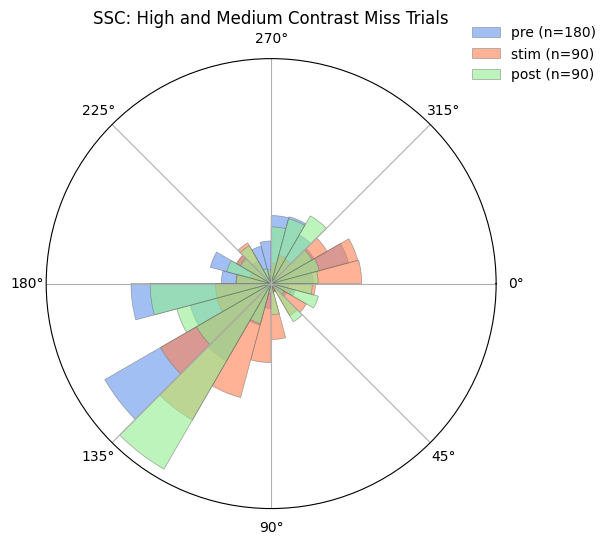

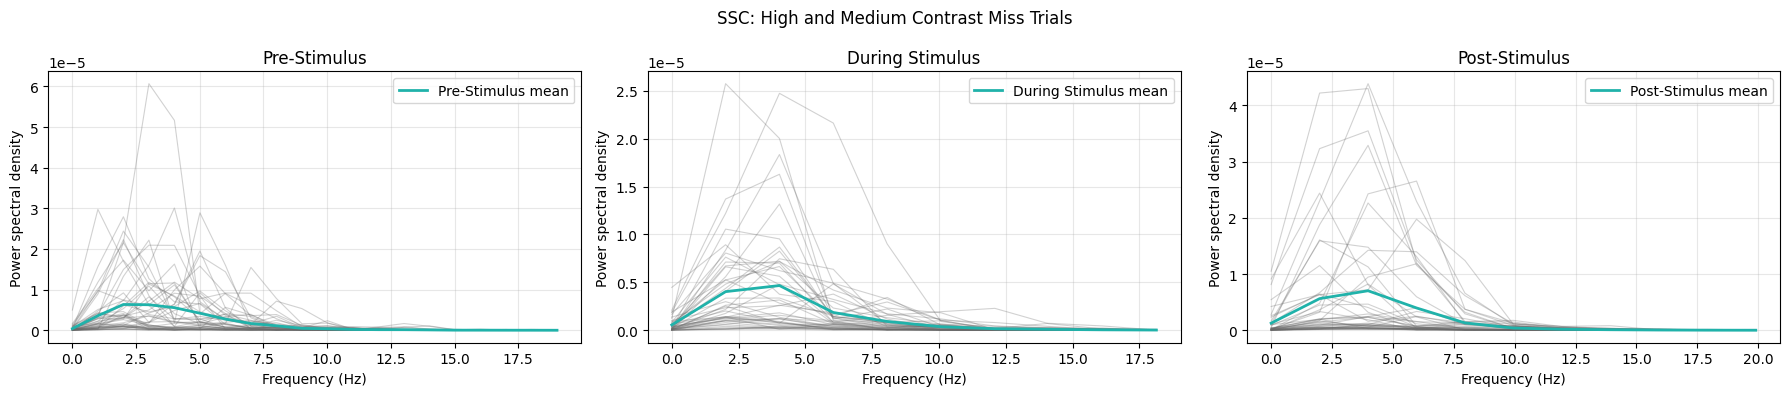

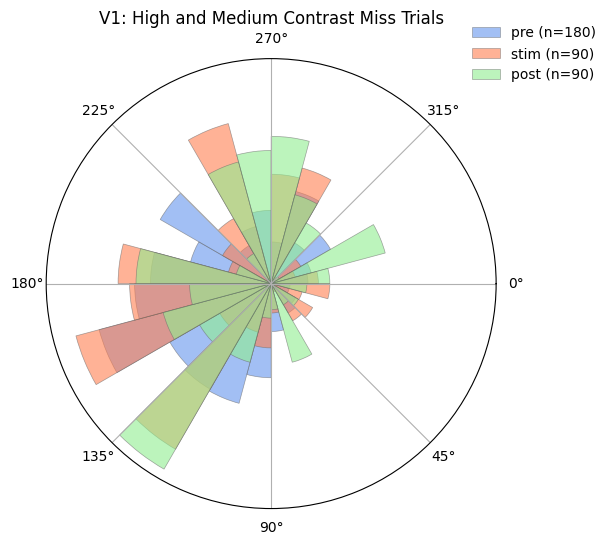

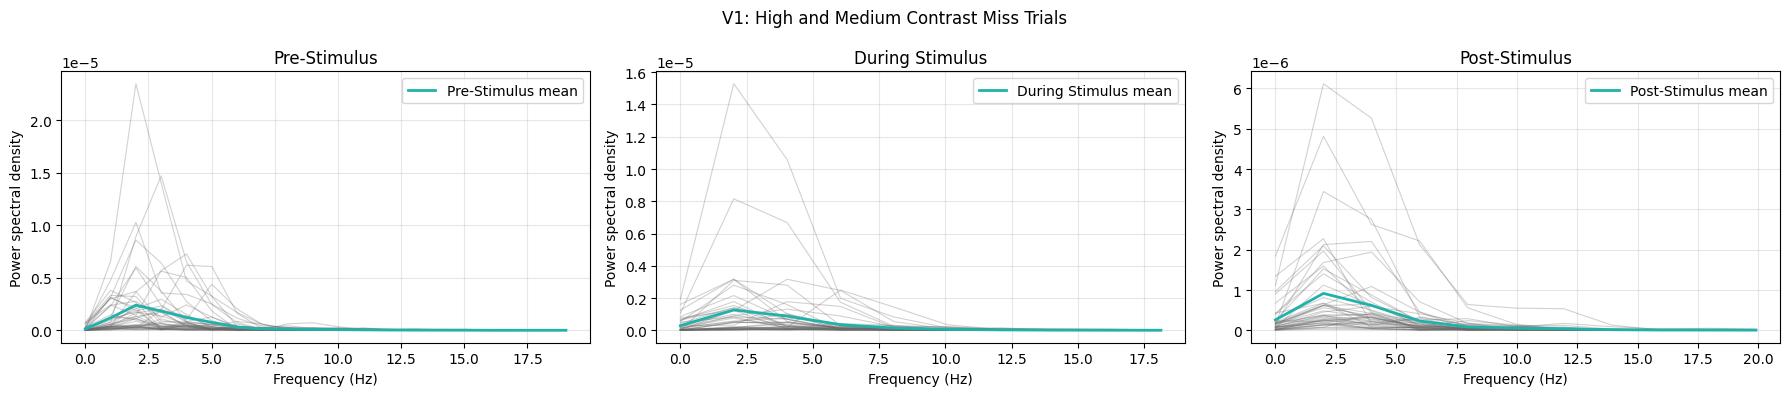

In [11]:
run_recording("cfm001mjr", 240508)

run_recording("cfm002mjr", 240514)

run_recording("cfm002mjr", 240516)

run_recording("cfm002mjr", 240517)

run_recording("cfm003mjr", 240513)